train.csv :
·      area_type: The type of the house area feature 'total_sqft' specifies.
·      availability: The availability date or availability status of the property.
·      location: The locality of the property in Bengaluru city.
·      size: The size of the housing property in BHK (or Bedrooms etc.,).
·      society: The name of the Apartment. This name is encrypted for confidentiality.
·      total_sqft: The 'area_type' area of the property.
·      bath: Number of bathrooms available in the house.
·      balcony: Number of balcony/balconies the house has.
·      price: Price of the housing property in Lakhs. (target feature)
 
The `test.csv` dataset contains similar information to train.csv but does not disclose the “price” feature. The price has to be predicted through your model.
 
avg_rent.csv :
·      location : The locality of the property in the bengaluru city.
·      avg_2bhk_rent : Average rent of two BHK flat in that location
 
 
dist_from_city_centre.csv : 
·      location : The locality of the property in the bengaluru city.
·      dist_from_city : Distance of the location from city center

In [ ]:
# pip install geopy

In [ ]:
# pip install geopandas

In [ ]:
# pip install geocoder

In [ ]:
# pip install xgboost

In [1]:
import numpy as np
import re
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

%matplotlib inline
import collections
import itertools
import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
#print(statsmodels.__version__)
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.utils import resample
from sklearn import preprocessing

from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from itertools import combinations

import geopandas as gpd
import geopy
import geopy.distance
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import BallTree, KDTree
import warnings

warnings.filterwarnings("ignore")

In [2]:
import geocoder
import math

def get_geocoder(location_string):
    result = geocoder.arcgis(location=location_string)
    if result.ok:
        lat, lon = result.latlng
        return str(lat).replace('-','') + "-" + str(lon).replace('-','')
    else:
        return np.nan
        # raise Exception(f"I have gotten a bad result for {location_string} :-(")


def get_geocode(location_string):
    locator = Nominatim(user_agent="myGeocoder")
    print(location_string)
    if location_string is np.nan :
        pass
    else:
        location = locator.geocode((location_string + ", Bangalore, Karnataka, India").lower().strip().replace('  ', ' '))
        if location is None:
            return get_geocoder(location_string)
        else:
            return str(location.latitude).replace('-','') + "-" + str(location.longitude).replace('-','')

def fill_empty_rows(df):
    uniq_loc_missing_lat = df.loc[df['loc_lat']==""]['location'].unique()
    uniq_loc_missing_long = df.loc[df['loc_long']==""]['location'].unique()
    unique_loc_missing_dir = df.loc[df['dir_from_centre']==""]['location'].unique()
    location_coord_dict = {}
    loc_direction_dict = {}
    for location in uniq_loc_missing_lat:
        location_coord_dict[location] = get_geocode(location)
    for location in uniq_loc_missing_long:
        location_coord_dict[location] = get_geocode(location)
    for location in unique_loc_missing_dir:
        loc_direction_dict[location] = get_direction_from_city_centre(get_geocode(location))
        
    for index, rows in df.loc[df['loc_lat']==""].iterrows():
        if str(df.loc[index, 'location']).lower() == "nan":
            pass
        else:
            if location_coord_dict.get(df.loc[index, 'location']) is np.nan:
                df.loc[index, 'loc_lat'] = np.nan
            else:
                df.loc[index,'loc_lat'] = location_coord_dict[df.loc[index,'location']].split("-")[0]
    
    for index, rows in df.loc[df['loc_long']==""].iterrows():
        if str(df.loc[index, 'location']).lower() == "nan":
            pass
        else:
            if location_coord_dict.get(df.loc[index, 'location']) is np.nan:
                df.loc[index, 'loc_long'] = np.nan
            else:
                df.loc[index,'loc_long'] = location_coord_dict[df.loc[index,'location']].split("-")[1]
    
    for index, rows in df.loc[df['dir_from_centre']==""].iterrows():
        if str(df.loc[index, 'location']).lower() == "nan":
            pass
        else:
            if loc_direction_dict.get(df.loc[index, 'location']) is np.nan:
                df.loc[index, 'dir_from_centre'] = np.nan
            else:
                df.loc[index,'dir_from_centre'] = loc_direction_dict[df.loc[index,'location']]   
    
    print(f"Still {len(df.loc[df['loc_lat']==''])} rows dont have Location latitudes coordinates.")
    print(f"Still {len(df.loc[df['loc_long']==''])} rows dont have Location longitudes coordinates.")
    print(f"Still {len(df.loc[df['dir_from_centre']==''])} rows dont have Directions.")
    return df
        

def fill_geo_codes(df):
    unique_locations_train = df['location'].unique()
    loc_lat_long = {}
    loc_direction_from_city_centre = {}
    for location in unique_locations_train:
        geocode_location = get_geocode(location)
        direction = ''
        if geocode_location is np.nan:
            direction = np.nan
        else:
            direction = get_direction_from_city_centre(geocode_location)
        loc_lat_long[location] = geocode_location
        loc_direction_from_city_centre[location] = direction
    df["loc_lat"] = ""
    df["loc_long"] = ""
    df["dir_from_centre"] = ""
    for index, row in df.iterrows():    
        if str(df.loc[index, 'location']).lower() == "nan":
            pass
        else:
            if loc_lat_long.get(df.loc[index, 'location']) is np.nan:
                df.loc[index, 'loc_lat'] = np.nan
                df.loc[index, 'loc_long'] = np.nan
            elif loc_lat_long.get(df.loc[index, 'location']):
                df.loc[index, 'loc_lat'] = loc_lat_long[df.loc[index, 'location']].split("-")[0]
                df.loc[index, 'loc_long'] = loc_lat_long[df.loc[index, 'location']].split("-")[1]
            if loc_direction_from_city_centre.get(df.loc[index, 'location']) is np.nan:
                df.loc[index, 'dir_from_centre'] = np.nan
            elif loc_direction_from_city_centre.get(df.loc[index, 'location']):
                df.loc[index, 'dir_from_centre'] = loc_direction_from_city_centre[df.loc[index, 'location']]
    return df
    


def calcBearing (lat1, long1, lat2, long2):
    dLon = (long2 - long1)
    x = math.cos(math.radians(lat2)) * math.sin(math.radians(dLon))
    y = math.cos(math.radians(lat1)) * math.sin(math.radians(lat2)) - math.sin(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(dLon))
    bearing = math.atan2(x,y)   # use atan2 to determine the quadrant
    bearing = math.degrees(bearing)

    return bearing

def calcNSEW(lat1, long1, lat2, long2):
    points = ["north", "north east", "east", "south east", "south", "south west", "west", "north west"]
    bearing = calcBearing(lat1, long1, lat2, long2)
    bearing += 22.5
    bearing = bearing % 360
    bearing = int(bearing / 45) # values 0 to 7
    NSEW = points [bearing]

    return NSEW
    
    
def get_direction_from_city_centre(received_geocode):
    central_bang_lat = 12.972442
    central_bang_long = 77.580643
    if received_geocode == "nan" or received_geocode is None:
        return np.nan
    elif received_geocode is np.nan:
        return np.nan
    else:
        print(received_geocode)
        received_lat = float(received_geocode.split('-')[0])
        received_long = float(received_geocode.split('-')[1])
    return calcNSEW(central_bang_lat, central_bang_long, received_lat, received_long)


def get_distance_from_city_centre(received_location):
    # lat_long_str = get_geocode(received_location)
    print(f"{received_location}")
    lat_long_str = get_geocoder(f"{received_location}, Bangalore, Karnataka")
    lat = lat_long_str.split('-')[0]
    long = lat_long_str.split('-')[1]
    print(f"{received_location} - {lat} | {long}")
    central_bang_lat = 12.972442
    central_bang_long = 77.580643
    return geopy.distance.geodesic((lat,long), (central_bang_lat,central_bang_long)).km
    

# TRIAL RUN
get_distance_from_city_centre("sanne amanikere")

# Replace these regions in train and test data with the corresponding regions, so that we can get the location coordinates
# devasthanagalu : varthur
# javarandoddi : rr nagar
# volagerekallahalli : Chikkadasarahalli

sanne amanikere
sanne amanikere - 12.966180000000065 | 77.58690000000007


0.9699449230858883

In [ ]:
# EITHER THIS TO BE RUN OR THE BELOW CELL FOR READING THE DATA, BUT NOT BOTH TOGETHER
df = pd.read_csv("train.csv")
df_rent = pd.read_csv("avg_rent.csv")
df_dist = pd.read_csv("dist_from_city_centre.csv")
df_test = pd.read_csv("test.csv")

# Filling the geocodes in Test data
df = fill_geo_codes(df)
df_test = fill_geo_codes(df_test)


In [ ]:
# Filling the geocodes in Test data
df = fill_empty_rows(df)
df_test = fill_empty_rows(df_test)

df.to_csv("train_with_loc_coordinates.csv")
df_test.to_csv("test_with_loc_coordinates.csv")

In [3]:
# Once COORDINATES ARE ALREADY WRITTEN
df = pd.read_csv("train_with_loc_coordinates.csv")
df_rent = pd.read_csv("avg_rent.csv")
df_dist = pd.read_csv("dist_from_city_centre.csv")
df_test = pd.read_csv("test_with_loc_coordinates.csv")
df.head()

,Unnamed: 0,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price,loc_lat,loc_long,dir_from_centre
0,0,0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,12.846854,77.676927,south east
1,1,1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,12.895768,77.867101,east
2,2,2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,12.905568,77.545544,south west
3,3,3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,13.001290,77.479070,west
4,4,4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,13.061360,77.649389,north east


In [4]:
df_test.head()

,Unnamed: 0,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,loc_lat,loc_long,dir_from_centre
0,0,0,Super built-up Area,Ready To Move,Chamrajpet,2 BHK,NaN,650,1.0,1.0,12.956997,77.563368,south west
1,1,1,Super built-up Area,Ready To Move,7th Phase JP Nagar,3 BHK,SrncyRe,1370,2.0,1.0,12.912432,77.575952,south
2,2,2,Super built-up Area,Ready To Move,Whitefield,3 BHK,AjhalNa,1725,3.0,2.0,12.969637,77.749745,east
3,3,3,Built-up Area,Ready To Move,Jalahalli,2 BHK,NaN,1000,2.0,0.0,13.046453,77.548380,north west
4,4,4,Plot Area,Ready To Move,TC Palaya,1 Bedroom,NaN,1350,1.0,0.0,13.009855,77.693089,east


In [5]:
# GLOBAL VARIABLES
set_locations_train_data = set(df['location'].unique())
set_locations_test_data = set(df_test['location'].unique())
set_location_dist = set(df_dist['location'].unique())
set_location_in_both_train_test_data = set_locations_test_data.intersection(set_locations_train_data)

def split_size(df, index, size):
    df.loc[index, 'room_count'] = str(size).split()[0]
    if str(size).split()[1] == "BHK":
        df.loc[index, 'hall'] = 1
        df.loc[index, 'kitchen'] = 1
    elif str(size).split()[1] == "RK":
        df.loc[index, 'hall'] = 0
        df.loc[index, 'kitchen'] = 1
    else:
        df.loc[index, 'hall'] = 0
        df.loc[index, 'kitchen'] = 0

def return_in_sq_ft(value, units):
    units = units.lower()
    value=float(value)
    if units=="grounds":
        return value*2400.352024
    elif units=="perch":
        return value*272.25
    elif units=="acres":
        return value*43560.00001
    elif units=="guntha":
        return value*1089
    elif units=="sq.yards":
        return value*9.000000878
    elif units=="sq.meter":
        return value*10.76391042
    elif units=="cents":
        return value*435.56
    else:
        print(f"{units} not FOUND")

def units_in_sq_ft(value):
    if re.search(r'[a-zA-Z]',value) != None:
        
        s_arr = re.findall(r'\d+[.]?\d*|[A-Za-z.]+', value)
        return return_in_sq_ft(s_arr[0], "".join(s_arr[1:]))
    elif value.find("-")!=-1:
        return (float(value.split("-")[0])+float(value.split("-")[1]))/2
    else:
        return float(value)
        


    

In [6]:
# Encoding Availability
df['availability'] = df['availability'].apply(lambda x: 1 if x=="Ready To Move" else 0)

In [7]:
# Lower casing the location name in train, dist and test data and finding the intersection
df['location'] = df['location'].apply(lambda x: str(x).lower().strip().replace('  ', ' '))
df_test['location'] = df_test['location'].apply(lambda x: str(x).lower().strip().replace('  ', ' '))
df_dist['location'] = df_dist['location'].apply(lambda x: str(x).lower().strip().replace('  ', ' '))

set_locations_train_data = set(df['location'].unique())
set_locations_test_data = set(df_test['location'].unique())
set_location_dist = set(df_dist['location'].unique())
set_location_in_both_train_test_data = set_locations_test_data.intersection(set_locations_train_data)

## PRELIMINARY CLEAN-UPS

In [8]:
df.balcony.value_counts()

2.0    4069
1.0    3894
3.0    1342
0.0     847
Name: balcony, dtype: int64

<AxesSubplot:xlabel='size', ylabel='balcony'>

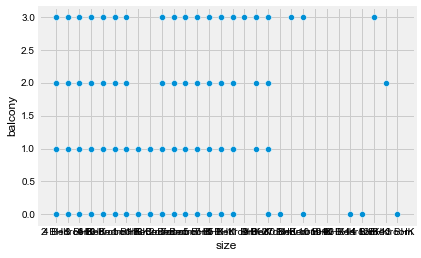

In [9]:
sns.scatterplot(x=df['size'], y=df.balcony)

In [10]:
df[df['balcony'].isna()]

,Unnamed: 0,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price,loc_lat,loc_long,dir_from_centre
6,6,6,Super built-up Area,0,old airport road,4 BHK,Jaades,2732,4.0,NaN,204.00,12.958383,77.666395,east
7,7,7,Super built-up Area,1,rajaji nagar,4 BHK,Brway G,3300,4.0,NaN,600.00,12.999522,77.550533,north west
9,9,9,Plot Area,1,gandhi bazar,6 Bedroom,NaN,1020,6.0,NaN,370.00,12.948277,77.570780,south
34,34,34,Built-up Area,1,kasturi nagar,3 BHK,Kantsce,1925,3.0,NaN,125.00,13.004498,77.660323,east
40,40,40,Built-up Area,1,murugeshpalya,2 BHK,Gentson,1296,2.0,NaN,81.00,12.958948,77.655593,east
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10560,10560,10560,Built-up Area,1,hsr layout,5 Bedroom,NaN,4200,5.0,NaN,245.00,12.911623,77.638862,south east
10561,10561,10561,Super built-up Area,1,thubarahalli,3 BHK,Asnts a,1540,3.0,NaN,90.00,12.954787,77.721315,east
10593,10593,10593,Built-up Area,1,marathahalli,4 Bedroom,Vemes H,3090,4.0,NaN,350.00,12.955257,77.698416,east
10634,10634,10634,Plot Area,0,rajankunte,NaN,NaN,1575,NaN,NaN,31.11,13.174134,77.565024,north


In [11]:
# Dropping the ID column for its redundancy
# Getting rid of society to avoid imputing huge amount of null values
# Availability doesnt much determine the price of a house
df.drop(columns=["ID", "society", "Unnamed: 0"], axis=1, inplace=True)

In [12]:
df.isna().sum()

area_type            0
availability         0
location             0
size                14
total_sqft           0
bath                65
balcony            504
price                0
loc_lat             17
loc_long            17
dir_from_centre     17
dtype: int64

In [13]:
# Replacing 1 NaN in location with mode of the dataset
df['location'] = df['location'].fillna('whitefield')

In [14]:
df['size'] = df['size'].fillna('2 BHK')

# Creating 3 additional columns
df['hall'] = np.nan
df['kitchen'] = np.nan
df['room_count'] = np.nan

In [15]:
# We are splitting the values in size into 3 columns:  Hall | Kitchen | Room_Count
# This is important as 1RK is different from 1 BHK


def split_size(df, index, size):
    df.loc[index, 'room_count'] = str(size).split()[0]
    if str(size).split()[1] == "BHK":
        df.loc[index, 'hall'] = 1
        df.loc[index, 'kitchen'] = 1
    elif str(size).split()[1] == "RK":
        df.loc[index, 'hall'] = 0
        df.loc[index, 'kitchen'] = 1
    else:
        df.loc[index, 'hall'] = 0
        df.loc[index, 'kitchen'] = 0
    


In [16]:
for index, row in df.iterrows():
    split_size(df, index, df.loc[index, 'size'])

df.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price,loc_lat,loc_long,dir_from_centre,hall,kitchen,room_count
0,Super built-up Area,0,electronic city phase ii,2 BHK,1056,2.0,1.0,39.07,12.846854,77.676927,south east,1.0,1.0,2
1,Plot Area,1,chikka tirupathi,4 Bedroom,2600,5.0,3.0,120.00,12.895768,77.867101,east,0.0,0.0,4
2,Built-up Area,1,uttarahalli,3 BHK,1440,2.0,3.0,62.00,12.905568,77.545544,south west,1.0,1.0,3
3,Super built-up Area,1,lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00,13.001290,77.479070,west,1.0,1.0,3
4,Super built-up Area,1,kothanur,2 BHK,1200,2.0,1.0,51.00,13.061360,77.649389,north east,1.0,1.0,2


In [17]:
df[['price','room_count','loc_lat','loc_long']] = df[['price','room_count','loc_lat','loc_long']].astype(float)

In [18]:
# For all rows where room_count is greater than 10, lets drop them
# Also our Test data has only rooms till 10.
df = df[df['room_count']<=10]
df = df[df['size']!='1 RK']
df.shape

(10632, 14)

In [19]:
df['bath'].median()

2.0

<AxesSubplot:ylabel='Density'>

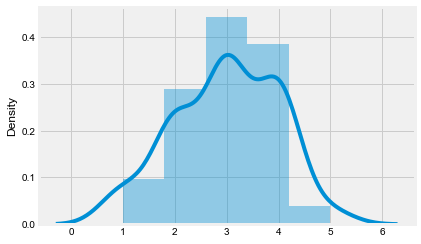

In [20]:
# Find majority of BHKs where the bathrooms is missing
df_bath_missing = df.loc[df['bath'].isna()]
sns.distplot(x=df_bath_missing['room_count'])

<AxesSubplot:xlabel='room_count', ylabel='bath'>

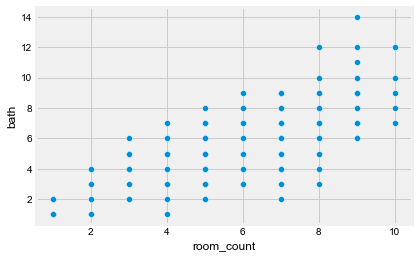

In [21]:
# And distribution of bathrooms as per room count
sns.scatterplot(x=df['room_count'], y=df['bath'])

In [22]:
median_bath_df = pd.DataFrame(df.groupby('room_count')['bath'].median())
median_bath_df

,bath
room_count,
1.0,1.0
2.0,2.0
3.0,3.0
4.0,4.0
5.0,5.0
6.0,6.0
7.0,7.0
8.0,7.5
9.0,9.0


In [23]:
# Filling the NaN values in bath with corresponding median for the respective room size
for index, row in df.iterrows():
    if np.isnan(df.loc[index, 'bath']):
        df.loc[index, 'bath'] = median_bath_df.loc[df.loc[index,'room_count']].values[0]

In [24]:
# Replacing all the NaN values in balcony witht the median of the subgroup based on number of rooms
balcony_df = pd.DataFrame(df.groupby('room_count')['balcony'].median())
balcony_df

,balcony
room_count,
1.0,1.0
2.0,1.0
3.0,2.0
4.0,2.0
5.0,2.0
6.0,2.0
7.0,2.0
8.0,2.0
9.0,2.0


In [25]:
# Setting the number of balconies as 3 for 10 BHK and 10 Bedroom has 3 balconies
balcony_df.fillna(3, inplace=True)

In [26]:
# Filling NaN values with corresponding mean for the respective room size
for index, row in df.iterrows():
    if np.isnan(df.loc[index, 'balcony']):
        df.loc[index, 'balcony'] = balcony_df.loc[df.loc[index,'room_count']].values[0]
df.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price,loc_lat,loc_long,dir_from_centre,hall,kitchen,room_count
0,Super built-up Area,0,electronic city phase ii,2 BHK,1056,2.0,1.0,39.07,12.846854,77.676927,south east,1.0,1.0,2.0
1,Plot Area,1,chikka tirupathi,4 Bedroom,2600,5.0,3.0,120.00,12.895768,77.867101,east,0.0,0.0,4.0
2,Built-up Area,1,uttarahalli,3 BHK,1440,2.0,3.0,62.00,12.905568,77.545544,south west,1.0,1.0,3.0
3,Super built-up Area,1,lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00,13.001290,77.479070,west,1.0,1.0,3.0
4,Super built-up Area,1,kothanur,2 BHK,1200,2.0,1.0,51.00,13.061360,77.649389,north east,1.0,1.0,2.0


In [27]:
df.isna().sum()

area_type           0
availability        0
location            0
size                0
total_sqft          0
bath                0
balcony             0
price               0
loc_lat            17
loc_long           17
dir_from_centre    17
hall                0
kitchen             0
room_count          0
dtype: int64

In [28]:
df.shape

(10632, 14)

In [29]:
df['size'].value_counts()

2 BHK         4160
3 BHK         3425
4 Bedroom      659
4 BHK          478
3 Bedroom      446
1 BHK          435
2 Bedroom      281
5 Bedroom      232
6 Bedroom      154
1 Bedroom       88
8 Bedroom       65
7 Bedroom       65
5 BHK           50
9 Bedroom       41
6 BHK           21
7 BHK           12
10 Bedroom       8
9 BHK            7
8 BHK            3
10 BHK           2
Name: size, dtype: int64

In [30]:
# Finding all the rows in total_sqft which contain different units
df['total_sqft_is_alphanumeric'] = list(map(lambda x: re.search(r'[a-zA-Z]',x) != None, df['total_sqft']))
df.loc[df['total_sqft_is_alphanumeric']==True].head(15)

,area_type,availability,location,size,total_sqft,bath,balcony,price,loc_lat,loc_long,dir_from_centre,hall,kitchen,room_count,total_sqft_is_alphanumeric
410,Super built-up Area,1,kengeri,1 BHK,34.46Sq. Meter,1.0,0.0,18.5,12.917657,77.483757,south west,1.0,1.0,1.0,True
648,Built-up Area,1,arekere,9 Bedroom,4125Perch,9.0,2.0,265.0,12.887209,77.596049,south,0.0,0.0,9.0,True
775,Built-up Area,1,basavanagara,1 BHK,1000Sq. Meter,2.0,1.0,93.0,12.900973,77.467125,south west,1.0,1.0,1.0,True
872,Super built-up Area,1,singapura village,2 BHK,1100Sq. Yards,2.0,1.0,45.0,26.225830,78.277580,north,1.0,1.0,2.0,True
1019,Plot Area,0,marathi layout,1 Bedroom,5.31Acres,1.0,0.0,110.0,12.997600,77.542100,north west,0.0,0.0,1.0,True
1086,Plot Area,0,narasapura,2 Bedroom,30Acres,2.0,2.0,29.5,13.204360,77.324505,north west,0.0,0.0,2.0,True
1400,Super built-up Area,1,chamrajpet,9 BHK,716Sq. Meter,9.0,1.0,296.0,12.956997,77.563368,south west,1.0,1.0,9.0,True
1712,Plot Area,1,singena agrahara,3 Bedroom,1500Sq. Meter,3.0,1.0,95.0,12.838353,77.715312,south east,0.0,0.0,3.0,True
1743,Super built-up Area,0,hosa road,3 BHK,142.61Sq. Meter,3.0,1.0,115.0,12.870607,77.654056,south east,1.0,1.0,3.0,True
1821,Plot Area,1,sarjapur,3 Bedroom,1574Sq. Yards,3.0,1.0,76.0,12.932267,77.683747,east,0.0,0.0,3.0,True


We can see that there are multiple units which are used here:
SqMeter/Acres/SqYards/Grounds/Cents/Guntha/Perch

Using calculators from https://housing.com/calculators/ground-to-square-feet
* 1 Ground =  2400.352024 sq.ft
* 1 Perch = 272.25 sq.ft
* 1 acre = 43560.00001 sq.ft
* 1 Guntha = 1089 sq.ft
* 1 sq.yards = 9.000000878 sq.ft
* 1 sq.meters = 10.76391042 sq.ft
* 1 Cents = 435.56 sq.ft

In [31]:
def return_in_sq_ft(value, units):
    units = units.lower()
    value=float(value)
    if units=="grounds":
        return value*2400.352024
    elif units=="perch":
        return value*272.25
    elif units=="acres":
        return value*43560.00001
    elif units=="guntha":
        return value*1089
    elif units=="sq.yards":
        return value*9.000000878
    elif units=="sq.meter":
        return value*10.76391042
    elif units=="cents":
        return value*435.56
    else:
        print(f"{units} not FOUND")

def units_in_sq_ft(value):
    if re.search(r'[a-zA-Z]',value) != None:
        
        s_arr = re.findall(r'\d+[.]?\d*|[A-Za-z.]+', value)
        return return_in_sq_ft(s_arr[0], "".join(s_arr[1:]))
    elif value.find("-")!=-1:
        return (float(value.split("-")[0])+float(value.split("-")[1]))/2
    else:
        return float(value)

df["total_sqft"] = df["total_sqft"].apply(units_in_sq_ft)

In [32]:
df.drop(columns=["total_sqft_is_alphanumeric"], inplace=True)

In [33]:
df.room_count.value_counts()

2.0     4441
3.0     3871
4.0     1137
1.0      523
5.0      282
6.0      175
7.0       77
8.0       68
9.0       48
10.0      10
Name: room_count, dtype: int64

In [34]:
df.shape

(10632, 14)

In [35]:
# Dropping columns
df.drop(columns=["size"], inplace=True)

### Finding all the unique Locations

In [36]:
unique_location_count = df.groupby("location")["location"].agg("count").sort_values(ascending = False)
unique_location_count

location
whitefield               433
sarjapur road            303
electronic city          234
kanakpura road           217
thanisandra              178
                        ... 
ganesha block              1
ganga nagar extension      1
rainbow drive              1
rahat bagh                 1
1a block koramangala       1
Name: location, Length: 1172, dtype: int64

In [37]:
unique_location_count_10 = unique_location_count[unique_location_count <= 10]

In [38]:
# df["location"] = df["location"].apply(lambda x : "other" if (x in unique_location_count_10) or (x not in set_location_in_both_train_test_data) else x)

In [39]:
# len(df['location'].unique())

### Adding per square-feet price

In [40]:
df['price_per_square_ft'] = (df['price']*100000)/df['total_sqft']
df.head()

,area_type,availability,location,total_sqft,bath,balcony,price,loc_lat,loc_long,dir_from_centre,hall,kitchen,room_count,price_per_square_ft
0,Super built-up Area,0,electronic city phase ii,1056.0,2.0,1.0,39.07,12.846854,77.676927,south east,1.0,1.0,2.0,3699.810606
1,Plot Area,1,chikka tirupathi,2600.0,5.0,3.0,120.00,12.895768,77.867101,east,0.0,0.0,4.0,4615.384615
2,Built-up Area,1,uttarahalli,1440.0,2.0,3.0,62.00,12.905568,77.545544,south west,1.0,1.0,3.0,4305.555556
3,Super built-up Area,1,lingadheeranahalli,1521.0,3.0,1.0,95.00,13.001290,77.479070,west,1.0,1.0,3.0,6245.890861
4,Super built-up Area,1,kothanur,1200.0,2.0,1.0,51.00,13.061360,77.649389,north east,1.0,1.0,2.0,4250.000000


Text(0, 0.5, 'Count')

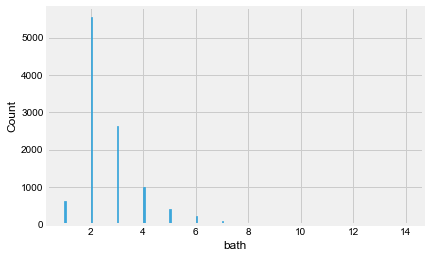

In [41]:
sns.histplot(df['bath'])
plt.ylabel('Count')

In [42]:
# Adding another categorical variable for big and small rooms
# df['room_size'] = np.nan
df["sqft_per_bhk"] = df['total_sqft']/df['room_count']
df.head(10)

,area_type,availability,location,total_sqft,bath,balcony,price,loc_lat,loc_long,dir_from_centre,hall,kitchen,room_count,price_per_square_ft,sqft_per_bhk
0,Super built-up Area,0,electronic city phase ii,1056.0,2.0,1.0,39.07,12.846854,77.676927,south east,1.0,1.0,2.0,3699.810606,528.000000
1,Plot Area,1,chikka tirupathi,2600.0,5.0,3.0,120.00,12.895768,77.867101,east,0.0,0.0,4.0,4615.384615,650.000000
2,Built-up Area,1,uttarahalli,1440.0,2.0,3.0,62.00,12.905568,77.545544,south west,1.0,1.0,3.0,4305.555556,480.000000
3,Super built-up Area,1,lingadheeranahalli,1521.0,3.0,1.0,95.00,13.001290,77.479070,west,1.0,1.0,3.0,6245.890861,507.000000
4,Super built-up Area,1,kothanur,1200.0,2.0,1.0,51.00,13.061360,77.649389,north east,1.0,1.0,2.0,4250.000000,600.000000
5,Super built-up Area,1,whitefield,1170.0,2.0,1.0,38.00,12.969637,77.749745,east,1.0,1.0,2.0,3247.863248,585.000000
6,Super built-up Area,0,old airport road,2732.0,4.0,2.0,204.00,12.958383,77.666395,east,1.0,1.0,4.0,7467.057101,683.000000
7,Super built-up Area,1,rajaji nagar,3300.0,4.0,2.0,600.00,12.999522,77.550533,north west,1.0,1.0,4.0,18181.818182,825.000000
8,Super built-up Area,1,marathahalli,1310.0,3.0,1.0,63.25,12.955257,77.698416,east,1.0,1.0,3.0,4828.244275,436.666667
9,Plot Area,1,gandhi bazar,1020.0,6.0,2.0,370.00,12.948277,77.570780,south,0.0,0.0,6.0,36274.509804,170.000000


In [43]:
# NOT CREATING A NEW COLUMN FOR ROOM SIZE
# for index, row in df.iterrows():
#     if df.loc[index,'sqft_per_bhk'] <= 300:
#         df.loc[index, 'room_size'] = 0
#     else:
#         df.loc[index, 'room_size'] = 1


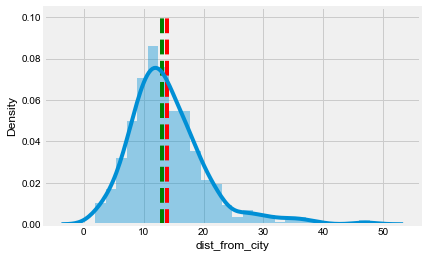

In [44]:
sns.distplot(df_dist['dist_from_city'], kde=True)
plt.vlines(x=df_dist['dist_from_city'].mean(), ymin=0, ymax=0.1, colors='r', linestyles='dashed')
plt.vlines(x=df_dist['dist_from_city'].median(), ymin=0, ymax=0.1, colors='g', linestyles='dashed')

In [45]:
def min_max_scale(x, min_val, max_val):
    return (x - min_val)/(max_val - min_val)

def get_dist(location):
    # Getting appropriate distance for all locations
    if location in df_dist['location'].unique():
        return df_dist.loc[df_dist['location'] == location]['dist_from_city'].values[0]
    else:
        return get_distance_from_city_centre(location)

In [46]:
df['dist'] = df['location'].apply(get_dist)
df.head()

gandhi bazar
gandhi bazar - 12.944800000000043 | 77.57212000000004
mangammanapalya
mangammanapalya - 12.904510000000073 | 77.64008000000007
himagiri meadows
himagiri meadows - 12.860770000000059 | 77.59295000000003
adarsh nagar
adarsh nagar - 12.930985050243784 | 77.60108506660958
govindaraja nagar ward
govindaraja nagar ward - 12.961370000000045 | 77.53437000000008
tharabanahalli
tharabanahalli - 13.101240000000075 | 77.48206000000005
double road
double road - 12.878360300715519 | 77.55560578261733
kodanda reddy layout
kodanda reddy layout - 13.016200000000026 | 77.71100000000007
t dasarahalli
t dasarahalli - 13.048160000000053 | 77.51509000000004
lakshmiamma garden
lakshmiamma garden - 12.955740000000048 | 77.59921000000008
ramaswamy palya - kammanahalli main road
ramaswamy palya - kammanahalli main road - 13.005079524268655 | 77.63608288328795
dinnur
dinnur - 13.025730000000067 | 77.59879000000006
sanjeevini nagar
sanjeevini nagar - 12.971190000000036 | 77.52288000000004
yarandahall

kariyammana agrahara - 12.937150000000031 | 77.68694000000005
binnamangala
binnamangala - 12.978670000000022 | 77.64078000000006
basava nagar
basava nagar - 12.969610000000046 | 77.68237000000005
canara bank layout
canara bank layout - 13.06809000000004 | 77.57958000000008
narasapura
narasapura - 12.799420000000055 | 77.80221000000006
mango garden layout
mango garden layout - 12.90551000000005 | 77.64735000000007
bidere agarahara, behind safal market
bidere agarahara, behind safal market - 13.128180000000043 | 77.45574000000005
grihalakshmi layout
grihalakshmi layout - 13.029660000000035 | 77.49967000000004
dodda kempaiah layout
dodda kempaiah layout - 13.03890000000007 | 77.57105000000007
hanumanth nagar
hanumanth nagar - 12.943720000000042 | 77.56120000000004
hunasamaranahalli
hunasamaranahalli - 13.144420000000025 | 77.61972000000003
kullappa colony
kullappa colony - 12.966590000000053 | 77.65318000000008
williams town
williams town - 13.000440000000026 | 77.60805000000005
jaya naga

5th block koramangala - 12.934300000000064 | 77.62261000000007
jakkuryelahanka
jakkuryelahanka - 13.08271063332865 | 77.60978655728722
manjunatha layout
manjunatha layout - 13.043600000000026 | 77.62521000000004
kashi nagar
kashi nagar - 12.898790000000076 | 77.56916000000007
someshwara layout
someshwara layout - 12.904760000000067 | 77.69575000000003
kathreguppe
kathreguppe - 12.926230000000032 | 77.54512000000005
hal 3rd stage
hal 3rd stage - 12.974610000000041 | 77.65363000000008
rajagopala nagar
rajagopala nagar - 13.012450000000058 | 77.51519000000008
bahubali nagar
bahubali nagar - 13.044710000000066 | 77.55008000000004
lottegolla halli
lottegolla halli - 13.047890000000052 | 77.57192000000003
nandini layout
nandini layout - 13.014810000000068 | 77.53891000000004
vibhutipura extension
vibhutipura extension - 13.048400049120374 | 77.57540006543294
b channasandra
b channasandra - 13.008980000000065 | 77.66059000000007
harappanahalli
harappanahalli - 12.79078000000004 | 77.622860000

mathikere sbm colony - 13.032340000000033 | 77.55864000000008
white field,kadugodi
white field,kadugodi - 12.991404217953267 | 77.75600324147136
vinayak nagar
vinayak nagar - 13.035100000000057 | 77.58961000000005
p krishnappa layout
p krishnappa layout - 13.006410000000074 | 77.62756000000007
green garden layout
green garden layout - 13.030250043622338 | 77.68392509207311
crimson layout
crimson layout - 13.004229689045012 | 77.6068259736432
adityanagar
adityanagar - 13.085810000000038 | 77.55144000000007
hanumantha nagar
hanumantha nagar - 12.943720000000042 | 77.56120000000004
t dasarahalli
t dasarahalli - 13.048160000000053 | 77.51509000000004
muthurayya swamy layout
muthurayya swamy layout - 12.990170000000035 | 77.50850000000008
goraguntepalya
goraguntepalya - 13.017520000000047 | 77.52633000000003
rajankunte
rajankunte - 13.171750000000031 | 77.56564000000003
6th block rajaji nagar
6th block rajaji nagar - 12.978320000000053 | 77.55396000000007
mla layout
mla layout - 13.04136000

bcc layout - 12.953190000000063 | 77.53032000000007
vinayak nagar
vinayak nagar - 13.035100000000057 | 77.58961000000005
madanayakahalli
madanayakahalli - 13.066374869688259 | 77.47431866427709
jaladarsini layout
jaladarsini layout - 13.030580000000043 | 77.57053000000008
tasker town
tasker town - 12.98762000000005 | 77.60166000000004
raghavendra nagar
raghavendra nagar - 13.020390000000077 | 77.67380000000009
milk colony
milk colony - 12.966590000000053 | 77.65318000000008
basnashankari,6th stage,
basnashankari,6th stage, - 12.879470000000026 | 77.50697000000008
coffee board layout
coffee board layout - 13.050310000000025 | 77.60710000000006
shirdi sai layout
shirdi sai layout - 12.946792149662366 | 77.716525874269
near ullas theater
near ullas theater - 13.019860000000051 | 77.55133000000006
chikkakannalli
chikkakannalli - 12.896660000000054 | 77.69607000000008
bhuvaneswari nagar
bhuvaneswari nagar - 12.942350000000033 | 77.48953000000006
yeshwanthpur industrial suburb
yeshwanthpur i

omarbagh layout - 13.004229689045012 | 77.6068259736432
chikkasandra
chikkasandra - 13.065480000000036 | 77.50831000000005
akshayanagara west
akshayanagara west - 13.020650000000046 | 77.68449000000004
escorts colony
escorts colony - 13.09916000000004 | 77.56571000000008
asha township, off hennur road
asha township, off hennur road - 13.031776312257257 | 77.64417512404776
1a block koramangala
1a block koramangala - 12.920040000000029 | 77.62546000000003
near international airport
near international airport - 13.199620000000039 | 77.70823000000007
nti layout
nti layout - 13.077300000000037 | 77.55626000000007
fraser town
fraser town - 12.998940000000061 | 77.61276000000004
dasappa layout
dasappa layout - 13.024260000000027 | 77.65683000000007
sonam layout
sonam layout - 13.004229689045012 | 77.6068259736432
cr layout
cr layout - 13.009219868377627 | 77.68910093306411
btm 4th stage
btm 4th stage - 12.892020000000059 | 77.61336000000006
arekempanahalli
arekempanahalli - 13.110430000000065

kumbena agrahara - 13.00216000000006 | 77.74780000000004
anekal - hosur road
anekal - hosur road - 12.953305580250724 | 77.58641919284628
4th block jayanagar
4th block jayanagar - 12.928670000000068 | 77.58263000000005
jyothi nagar
jyothi nagar - 12.967620000000068 | 77.66791000000006
silver springs layout
silver springs layout - 12.951140000000066 | 77.71219000000008
kaveri nagar
kaveri nagar - 13.016840000000059 | 77.52677000000006
crimson layout
crimson layout - 13.004229689045012 | 77.6068259736432
2nd phase jp nagar, jp nagar
2nd phase jp nagar, jp nagar - 12.909330000000068 | 77.59153000000003
mathikere extension
mathikere extension - 13.009827096387854 | 77.57806018117894
ashwini layout
ashwini layout - 12.939860000000067 | 77.62813000000006
indra nagar
indra nagar - 13.030060000000049 | 77.49526000000003
moodalapalya
moodalapalya - 12.970762346831364 | 77.52508035172923
beml layout 5th stage
beml layout 5th stage - 12.908430000000067 | 77.52103000000005
manonarayanapalya
manona

electronic city phase 1, - 12.83907000000005 | 77.65912000000003
naidu layout
naidu layout - 13.084150000000022 | 77.53465000000006
sugama layout
sugama layout - 13.145259011895863 | 77.61622238054257
behind don bosco church
behind don bosco church - 13.007670000000076 | 77.62997000000007
seshadripuram
seshadripuram - 12.993550000000027 | 77.57988000000006
bhel layout
bhel layout - 13.09292000000005 | 77.54819000000003
devara jeevanahalli
devara jeevanahalli - 13.014440000000036 | 77.59951000000007
1st block hbr layout
1st block hbr layout - 13.020070000000032 | 77.62446000000006
shanthi layout
shanthi layout - 13.01723000000004 | 77.68363000000005
anugrah layout
anugrah layout - 12.99216000000007 | 77.68371000000008
bandepalya
bandepalya - 12.898190000000056 | 77.63837000000007
bethel nagar
bethel nagar - 13.005040000000065 | 77.71660000000008
narayana nagar 1st block
narayana nagar 1st block - 12.88208000000003 | 77.55338000000006
poornaprajna layout
poornaprajna layout - 12.90308000

5th block jayanagar - 12.919070000000033 | 77.58589000000006
ksrtc layout
ksrtc layout - 12.994560000000035 | 77.49114000000003
banashankari 6th stage
banashankari 6th stage - 12.879470000000026 | 77.50697000000008
jnana ganga nagar
jnana ganga nagar - 13.014450000000068 | 77.58808000000005
shetty halli
shetty halli - 13.064424842203948 | 77.51137141954288
konena agrahara
konena agrahara - 12.95688000000007 | 77.66062000000005
sadanand nagar
sadanand nagar - 12.98983000000004 | 77.65099000000004
brindavan layout
brindavan layout - 13.023710000000051 | 77.66375000000005
bethel nagar
bethel nagar - 13.005040000000065 | 77.71660000000008
chambenahalli
chambenahalli - 12.87898000000007 | 77.76387000000005
p&t layout
p&t layout - 12.99303051356599 | 77.55361982247987
8th block jayanagar
8th block jayanagar - 12.920530000000042 | 77.57792000000006
cooketown
cooketown - 13.003630000000044 | 77.62283000000008
rajarajeshwarinagar
rajarajeshwarinagar - 12.93178000000006 | 77.52668000000006
kathr

,area_type,availability,location,total_sqft,bath,balcony,price,loc_lat,loc_long,dir_from_centre,hall,kitchen,room_count,price_per_square_ft,sqft_per_bhk,dist
0,Super built-up Area,0,electronic city phase ii,1056.0,2.0,1.0,39.07,12.846854,77.676927,south east,1.0,1.0,2.0,3699.810606,528.0,19.3
1,Plot Area,1,chikka tirupathi,2600.0,5.0,3.0,120.00,12.895768,77.867101,east,0.0,0.0,4.0,4615.384615,650.0,34.6
2,Built-up Area,1,uttarahalli,1440.0,2.0,3.0,62.00,12.905568,77.545544,south west,1.0,1.0,3.0,4305.555556,480.0,12.9
3,Super built-up Area,1,lingadheeranahalli,1521.0,3.0,1.0,95.00,13.001290,77.479070,west,1.0,1.0,3.0,6245.890861,507.0,21.4
4,Super built-up Area,1,kothanur,1200.0,2.0,1.0,51.00,13.061360,77.649389,north east,1.0,1.0,2.0,4250.000000,600.0,11.8


## CHECKING FOR OUTLIERS

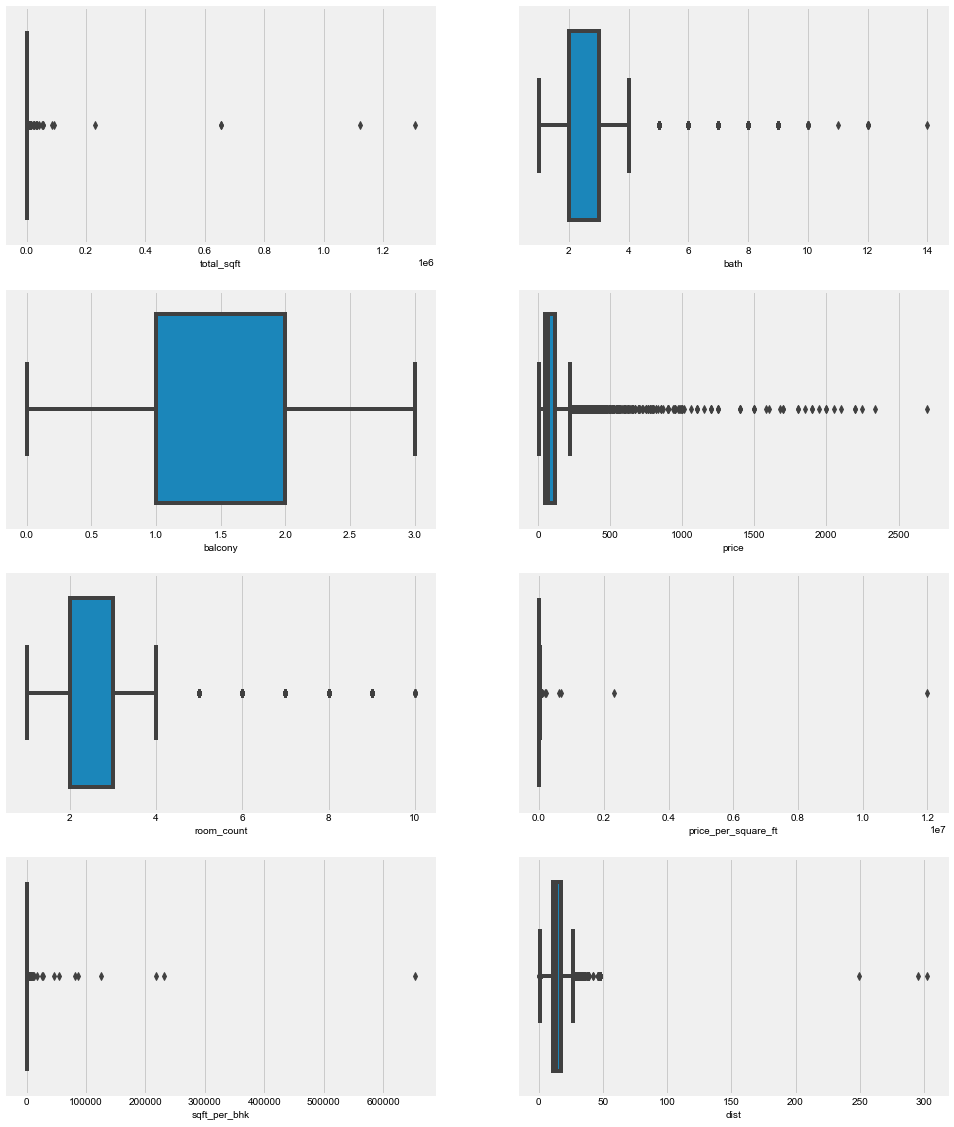

In [47]:
df_num = df.select_dtypes(include=np.number)
# Dropping the categorical columns which are only numerically encoded
df_num.drop(columns=["availability","hall","kitchen","loc_lat","loc_long"], inplace=True)
fig,ax = plt.subplots(4,2, figsize=(15,20))

for col, sub in zip(df_num, ax.flatten()):
    z=sns.boxplot(x=df_num[col], ax=sub, orient='h')
    z.set_xlabel(col, fontsize=10)

We are keeping the outliers for price, as we might be needed to predict such cases in Test Data

In [48]:
# Getting rid of the outliers from originally numeric column
# for col in df_num.columns:
#     tempdata = df_num[col]
#     q1,q3 = tempdata.quantile([0.25,0.75])
#     IQR = q3-q1
#     print(col, q1,q3, IQR)
#     lr = q1-1.5*IQR
#     ur = q3+1.5*IQR
#     # Replacing the values 
#     df_num[col] = df_num[col].apply(lambda x: x if x <= ur else ur)
#     df_num[col] = df_num[col].apply(lambda x: x if x >= lr else lr)


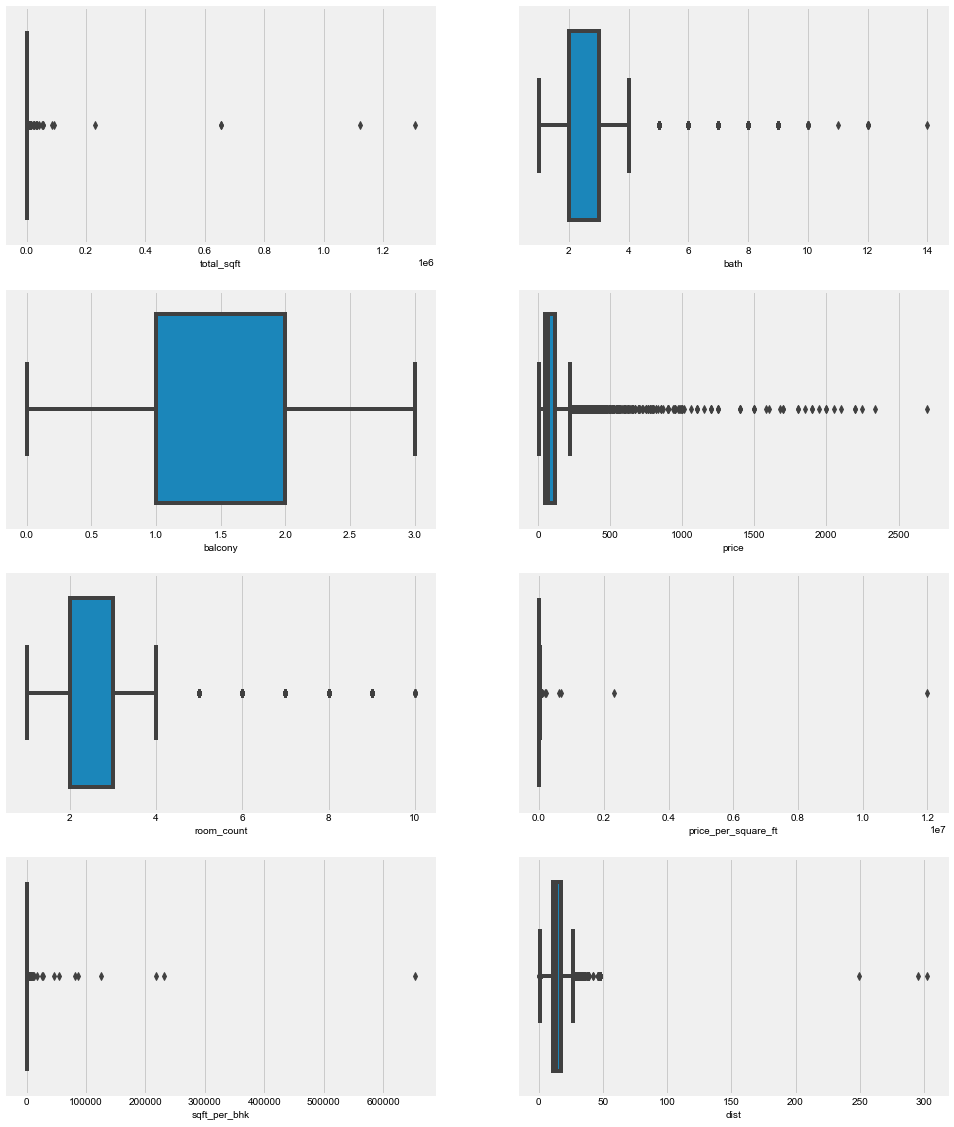

In [49]:
# Boxplot after getting rid of the outliers
fig,ax = plt.subplots(4,2, figsize=(15,20))
for col, sub in zip(df_num, ax.flatten()):
    z=sns.boxplot(x=df_num[col], ax=sub, orient='h')
    z.set_xlabel(col, fontsize=10)

In [50]:
df_1 = pd.concat([df.drop(columns=df_num.columns), df_num], axis=1)
print(df_1.shape)
df_1.head()

(10632, 16)


,area_type,availability,location,loc_lat,loc_long,dir_from_centre,hall,kitchen,total_sqft,bath,balcony,price,room_count,price_per_square_ft,sqft_per_bhk,dist
0,Super built-up Area,0,electronic city phase ii,12.846854,77.676927,south east,1.0,1.0,1056.0,2.0,1.0,39.07,2.0,3699.810606,528.0,19.3
1,Plot Area,1,chikka tirupathi,12.895768,77.867101,east,0.0,0.0,2600.0,5.0,3.0,120.00,4.0,4615.384615,650.0,34.6
2,Built-up Area,1,uttarahalli,12.905568,77.545544,south west,1.0,1.0,1440.0,2.0,3.0,62.00,3.0,4305.555556,480.0,12.9
3,Super built-up Area,1,lingadheeranahalli,13.001290,77.479070,west,1.0,1.0,1521.0,3.0,1.0,95.00,3.0,6245.890861,507.0,21.4
4,Super built-up Area,1,kothanur,13.061360,77.649389,north east,1.0,1.0,1200.0,2.0,1.0,51.00,2.0,4250.000000,600.0,11.8


In [51]:
# Erasing the outliers from each group of locations
def remove_pps_outliers(df):
    df_out=pd.DataFrame()
    for key,subdf in df.groupby('location'):
        m=np.mean(subdf.price_per_square_ft)
        st=np.std(subdf.price_per_square_ft)
        reduced_df=subdf[(subdf.price_per_square_ft>=(m-3*st))& (subdf.price_per_square_ft<=(m+3*st))]
        df_out=pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

# df_2=remove_pps_outliers(df_1)
df_2 = df_1.copy()
df_2.shape

(10632, 16)

<AxesSubplot:xlabel='sqft_per_bhk', ylabel='Density'>

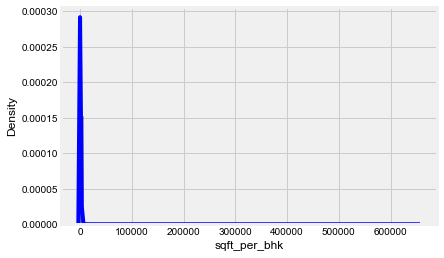

In [52]:
sns.distplot(df_2["sqft_per_bhk"], hist=True, kde=True, bins=100, color='blue', hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='total_sqft', ylabel='Density'>

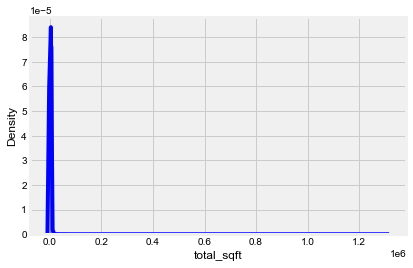

In [53]:
sns.distplot(df_2["total_sqft"], hist=True, kde=True, bins=100, color='blue', hist_kws={'edgecolor':'black'})

In [54]:
def plot_multiple_size_with_price(size_1, size_2, location, df):
    bhk_first = df[(df['location']==location) & (df['room_count']==size_1)]
    big_bhk_first = bhk_first[bhk_first['room_size']==1]
    small_bhk_first = bhk_first[bhk_first['room_size']==0]
    bhk_second = df[(df['location']==location) & (df['room_count']==size_2)]
    big_bhk_second = bhk_second[bhk_second['room_size']==1]
    small_bhk_second = bhk_second[bhk_second['room_size']==0]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(big_bhk_first.total_sqft,big_bhk_first.price,color='blue',label=str(size_1)+" BHK", s=50)
    plt.scatter(big_bhk_second.total_sqft,big_bhk_second.price,marker='+',color='red',label=str(size_2)+" BHK", s=50)
    
    plt.xlabel("Total Square Feet Area - Big HOUSES")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    plt.show()
        

# plot_multiple_size_with_price(1,2, "whitefield", df_2)

In [55]:
# plot_multiple_size_with_price(2,3, "whitefield", df_2)

In [56]:
# plot_multiple_size_with_price(3,4, "hebbal", df_2)

In a location, when the square feet increases as well as the number of rooms increase, still certain houses with lower space and room number are priced higher than larger houses. Those rows need to be removed. We will find the mean price of a house of a particular size. And if the per square foot rate of the house is less than mean of smaller size house, then we will get rid of it.

In [57]:
def remove_irregularly_priced_houses(df):
    exclusion_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for size, size_df in location_df.groupby(['room_count']):
            bhk_stats[size] = {
                'mean': np.mean(size_df.price_per_square_ft),
                'std': np.std(size_df.price_per_square_ft),
                'count': size_df.shape[0]
            }
        for size, size_df in location_df.groupby('room_count'):
            stats = bhk_stats.get(size-1)
            if stats and stats['count'] >= 5:
                exclusion_indices = np.append(exclusion_indices, size_df[size_df.price_per_square_ft<(stats['mean'])].index.values)
    return df.drop(exclusion_indices, axis='index')

In [58]:
# df_3 = remove_irregularly_priced_houses(df_2)
df_3 = df_2.copy()
df_3.shape

(10632, 16)

In [59]:
# plot_multiple_size_with_price(2,3, "whitefield", df_3)

We can see that the number of 3 BHKs with lesser price-per-square-feet as compared to 2 BHK are removed.

## Doing PREPROCESSING

In order to have the same number of columns in both train and test data, we need to set any location which is not present in both train and test data as other

In [60]:
df_3.corr()["price"].sort_values(ascending=False)

price                  1.000000
bath                   0.478295
room_count             0.423027
balcony                0.136321
total_sqft             0.046730
availability           0.028014
price_per_square_ft    0.025574
sqft_per_bhk           0.016835
loc_lat                0.005213
loc_long              -0.008990
dist                  -0.139576
hall                  -0.303702
kitchen               -0.303702
Name: price, dtype: float64

In [61]:
df_3.drop(columns=['price_per_square_ft',], inplace=True)

In [62]:
df_3.isna().sum()

area_type           0
availability        0
location            0
loc_lat            17
loc_long           17
dir_from_centre    17
hall                0
kitchen             0
total_sqft          0
bath                0
balcony             0
price               0
room_count          0
sqft_per_bhk        0
dist                0
dtype: int64

In [63]:
df_3.dropna(inplace=True)

In [64]:
df_3.head()

,area_type,availability,location,loc_lat,loc_long,dir_from_centre,hall,kitchen,total_sqft,bath,balcony,price,room_count,sqft_per_bhk,dist
0,Super built-up Area,0,electronic city phase ii,12.846854,77.676927,south east,1.0,1.0,1056.0,2.0,1.0,39.07,2.0,528.0,19.3
1,Plot Area,1,chikka tirupathi,12.895768,77.867101,east,0.0,0.0,2600.0,5.0,3.0,120.00,4.0,650.0,34.6
2,Built-up Area,1,uttarahalli,12.905568,77.545544,south west,1.0,1.0,1440.0,2.0,3.0,62.00,3.0,480.0,12.9
3,Super built-up Area,1,lingadheeranahalli,13.001290,77.479070,west,1.0,1.0,1521.0,3.0,1.0,95.00,3.0,507.0,21.4
4,Super built-up Area,1,kothanur,13.061360,77.649389,north east,1.0,1.0,1200.0,2.0,1.0,51.00,2.0,600.0,11.8


In [65]:
# Getting average price for each location and different room count
df_avg_price_for_aroom_in_any_location = pd.DataFrame(df_3.groupby(['location', 'loc_lat', 'loc_long', 'room_count', ])['price'].agg('median').sort_values(ascending=False))

In [66]:
df_3['estimated_price'] = ""

for index, row in df_3.iterrows():
    locate = df_3.loc[index,"location"]
    rc = df_3.loc[index,"room_count"]
    df_3.loc[index, 'estimated_price'] = df_avg_price_for_aroom_in_any_location.query('location==@locate and room_count==@rc').values[0]

In [67]:
df_3.head()

,area_type,availability,location,loc_lat,loc_long,dir_from_centre,hall,kitchen,total_sqft,bath,balcony,price,room_count,sqft_per_bhk,dist,estimated_price
0,Super built-up Area,0,electronic city phase ii,12.846854,77.676927,south east,1.0,1.0,1056.0,2.0,1.0,39.07,2.0,528.0,19.3,33.5
1,Plot Area,1,chikka tirupathi,12.895768,77.867101,east,0.0,0.0,2600.0,5.0,3.0,120.00,4.0,650.0,34.6,120.0
2,Built-up Area,1,uttarahalli,12.905568,77.545544,south west,1.0,1.0,1440.0,2.0,3.0,62.00,3.0,480.0,12.9,55.25
3,Super built-up Area,1,lingadheeranahalli,13.001290,77.479070,west,1.0,1.0,1521.0,3.0,1.0,95.00,3.0,507.0,21.4,110.0
4,Super built-up Area,1,kothanur,13.061360,77.649389,north east,1.0,1.0,1200.0,2.0,1.0,51.00,2.0,600.0,11.8,57.5


In [68]:
df_3['estimated_price'] = df_3[['estimated_price']].astype(float)
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10615 entries, 0 to 10655
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   area_type        10615 non-null  object 
 1   availability     10615 non-null  int64  
 2   location         10615 non-null  object 
 3   loc_lat          10615 non-null  float64
 4   loc_long         10615 non-null  float64
 5   dir_from_centre  10615 non-null  object 
 6   hall             10615 non-null  float64
 7   kitchen          10615 non-null  float64
 8   total_sqft       10615 non-null  float64
 9   bath             10615 non-null  float64
 10  balcony          10615 non-null  float64
 11  price            10615 non-null  float64
 12  room_count       10615 non-null  float64
 13  sqft_per_bhk     10615 non-null  float64
 14  dist             10615 non-null  float64
 15  estimated_price  10615 non-null  float64
dtypes: float64(12), int64(1), object(3)
memory usage: 1.6+ MB


In [69]:
price = df_3["price"].reset_index(drop=True)

In [70]:
price.head()

0     39.07
1    120.00
2     62.00
3     95.00
4     51.00
Name: price, dtype: float64

In [71]:
print(price.shape)

(10615,)


In [72]:
df_3.drop(["price"], axis=1, inplace=True)

In [73]:
# Ordinal Encoding to area_type
ordinal_encoding_area_dict = {"Carpet  Area":1, "Built-up  Area":2, "Plot  Area":4, "Super built-up  Area":3}
df_3['area_type'] = df_3['area_type'].map(ordinal_encoding_area_dict)

In [74]:

X_num = df_3.select_dtypes(include=np.number)
X_num.drop(columns=["availability", "area_type", "hall", "kitchen"], inplace=True)
out = price

column_list = X_num.columns
interactions = list(combinations(column_list, 2))

interaction_dict = {}
for interaction in interactions:
    print(interaction)
    int_2_cols = X_num.copy()
    int_2_cols['int'] = int_2_cols[interaction[0]] * int_2_cols[interaction[1]]
    lr = LinearRegression()
    lr.fit(int_2_cols, out)
    interaction_dict[lr.score(int_2_cols, out)] = interaction

top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
for interaction in top_5:
    print(interaction, interaction_dict[interaction])

('loc_lat', 'loc_long')
('loc_lat', 'total_sqft')
('loc_lat', 'bath')
('loc_lat', 'balcony')
('loc_lat', 'room_count')
('loc_lat', 'sqft_per_bhk')
('loc_lat', 'dist')
('loc_lat', 'estimated_price')
('loc_long', 'total_sqft')
('loc_long', 'bath')
('loc_long', 'balcony')
('loc_long', 'room_count')
('loc_long', 'sqft_per_bhk')
('loc_long', 'dist')
('loc_long', 'estimated_price')
('total_sqft', 'bath')
('total_sqft', 'balcony')
('total_sqft', 'room_count')
('total_sqft', 'sqft_per_bhk')
('total_sqft', 'dist')
('total_sqft', 'estimated_price')
('bath', 'balcony')
('bath', 'room_count')
('bath', 'sqft_per_bhk')
('bath', 'dist')
('bath', 'estimated_price')
('balcony', 'room_count')
('balcony', 'sqft_per_bhk')
('balcony', 'dist')
('balcony', 'estimated_price')
('room_count', 'sqft_per_bhk')
('room_count', 'dist')
('room_count', 'estimated_price')
('sqft_per_bhk', 'dist')
('sqft_per_bhk', 'estimated_price')
('dist', 'estimated_price')
0.7775051523324102 ('bath', 'room_count')
0.7773335589016905

In [75]:
# Taking combination of 3 columns
column_list = X_num.columns
interactions = list(combinations(column_list, 3))

interaction_dict = {}
for interaction in interactions:
    int_2_cols = X_num.copy()
    int_2_cols['int'] = int_2_cols[interaction[0]] * int_2_cols[interaction[1]] * int_2_cols[interaction[2]]
    lr = LinearRegression()
    lr.fit(int_2_cols, out)
    interaction_dict[lr.score(int_2_cols, out)] = interaction

top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
for interaction in top_5:
    print(interaction, interaction_dict[interaction])

0.7784294435387296 ('balcony', 'sqft_per_bhk', 'estimated_price')
0.7775034467139849 ('loc_long', 'bath', 'room_count')
0.7774174011091697 ('total_sqft', 'sqft_per_bhk', 'estimated_price')
0.7773754599998652 ('loc_lat', 'bath', 'room_count')
0.7773314761101102 ('loc_long', 'balcony', 'estimated_price')


In [76]:
# Taking combination of 4 columns
column_list = X_num.columns
interactions = list(combinations(column_list, 4))

interaction_dict = {}
for interaction in interactions:
    int_2_cols = X_num.copy()
    int_2_cols['int'] = int_2_cols[interaction[0]] * int_2_cols[interaction[1]] * int_2_cols[interaction[2]] * int_2_cols[interaction[3]]
    lr = LinearRegression()
    lr.fit(int_2_cols, out)
    interaction_dict[lr.score(int_2_cols, out)] = interaction

top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
for interaction in top_5:
    print(interaction, interaction_dict[interaction])
column_list

0.7787681871814117 ('total_sqft', 'balcony', 'sqft_per_bhk', 'estimated_price')
0.7784270459323885 ('loc_long', 'balcony', 'sqft_per_bhk', 'estimated_price')
0.7780367459504804 ('loc_lat', 'balcony', 'sqft_per_bhk', 'estimated_price')
0.7774868906311736 ('bath', 'balcony', 'sqft_per_bhk', 'estimated_price')
0.7774315058400169 ('loc_lat', 'total_sqft', 'sqft_per_bhk', 'estimated_price')


Index(['loc_lat', 'loc_long', 'total_sqft', 'bath', 'balcony', 'room_count',
       'sqft_per_bhk', 'dist', 'estimated_price'],
      dtype='object')

In [77]:
# Adding the interaction column from above
df_3['interaction'] = df_3['total_sqft'] * df_3['sqft_per_bhk'] * df_3['estimated_price']

In [78]:
df_3.head()

,area_type,availability,location,loc_lat,loc_long,dir_from_centre,hall,kitchen,total_sqft,bath,balcony,room_count,sqft_per_bhk,dist,estimated_price,interaction
0,3,0,electronic city phase ii,12.846854,77.676927,south east,1.0,1.0,1056.0,2.0,1.0,2.0,528.0,19.3,33.50,18678528.0
1,4,1,chikka tirupathi,12.895768,77.867101,east,0.0,0.0,2600.0,5.0,3.0,4.0,650.0,34.6,120.00,202800000.0
2,2,1,uttarahalli,12.905568,77.545544,south west,1.0,1.0,1440.0,2.0,3.0,3.0,480.0,12.9,55.25,38188800.0
3,3,1,lingadheeranahalli,13.001290,77.479070,west,1.0,1.0,1521.0,3.0,1.0,3.0,507.0,21.4,110.00,84826170.0
4,3,1,kothanur,13.061360,77.649389,north east,1.0,1.0,1200.0,2.0,1.0,2.0,600.0,11.8,57.50,41400000.0


In [79]:
# Dropping sqft_per_bhk as it will any way get dropped with lasso
df_3.drop(columns=['sqft_per_bhk'], inplace=True)

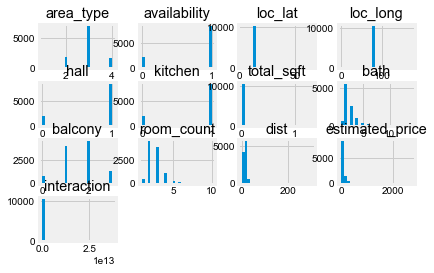

In [80]:
# Getting the distribution of the data before normalization
df_3.hist(bins=25)
plt.show()

In [81]:
from sklearn import preprocessing

h_num = df_3[['area_type','bath', 'balcony', 'total_sqft', 'interaction', 'room_count', 'dist', 'loc_lat', 'loc_long', 'estimated_price']].reset_index(drop=True)

# Log transformation of columns: loc_lat loc_long total_sqft dist estimated_price interaction
h_num['total_sqft'] = np.log(h_num['total_sqft'])
h_num['estimated_price'] = np.log(h_num['estimated_price'])
h_num['interaction'] = np.log(h_num['interaction'])



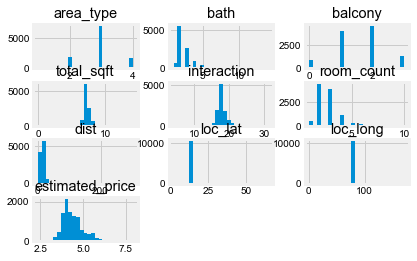

In [82]:
h_num.hist(bins=25)
plt.show()

In [83]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()
min_max_scaler = preprocessing.MinMaxScaler()
scaled_f = pd.DataFrame(rob_scaler.fit_transform(h_num), columns=h_num.columns)
print(scaled_f.shape)
scaled_f.head(10)

(10615, 10)


,area_type,bath,balcony,total_sqft,interaction,room_count,dist,loc_lat,loc_long,estimated_price
0,0.0,0.0,-1.0,-0.446870,-0.789588,-1.0,0.859375,-0.969333,0.398150,-0.985623
1,1.0,3.0,1.0,1.680776,1.219546,1.0,3.250000,-0.559158,2.162363,0.720873
2,-1.0,0.0,1.0,0.285520,-0.187089,0.0,-0.140625,-0.476978,-0.820663,-0.316473
3,0.0,1.0,-1.0,0.414745,0.485245,0.0,1.187500,0.325716,-1.437327,0.604501
4,0.0,0.0,-1.0,-0.145008,-0.119070,-1.0,-0.312500,0.829446,0.142693,-0.263087
5,0.0,0.0,-1.0,-0.204793,-0.154434,-1.0,0.546875,0.060280,1.073669,-0.251508
6,0.0,2.0,0.0,1.797717,1.737538,1.0,-0.609375,-0.034090,0.300446,1.410740
7,0.0,2.0,0.0,2.243752,2.795265,1.0,-0.656250,0.310893,-0.774381,2.584670
8,0.0,1.0,-1.0,0.062097,0.064562,0.0,-0.453125,-0.060301,0.597505,0.336117
9,1.0,4.0,0.0,-0.528775,0.249984,3.0,-1.657061,-0.118837,-0.586550,2.226841


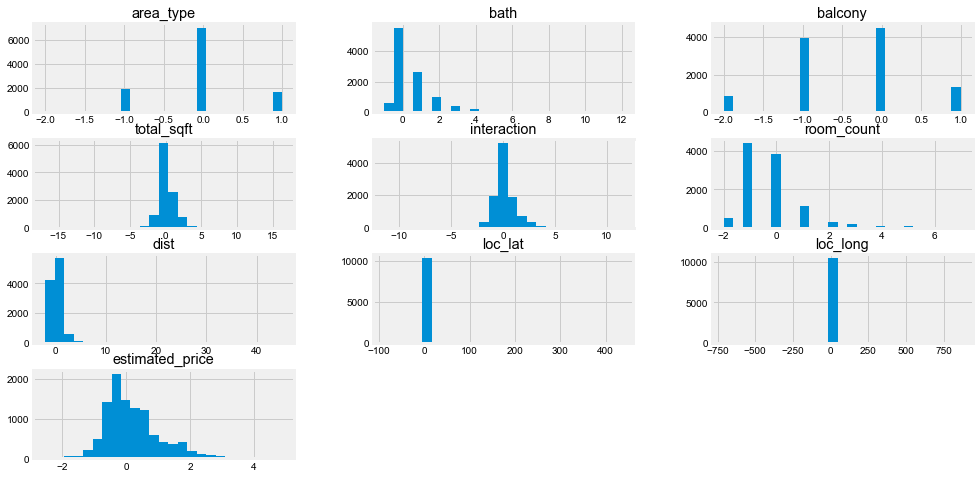

In [84]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

# Getting the distribution of the data after normalization
scaled_f.hist(bins=25)
plt.show()

In [85]:
dummies = pd.get_dummies(data=df_3.drop(columns=['area_type', 'location', 'bath', 'total_sqft', 'interaction', 'balcony', 'room_count', 'dist', 'loc_lat', 'loc_long', 'estimated_price']), columns=['dir_from_centre'], drop_first=True, prefix='', prefix_sep='')
print(dummies.shape)
dummies.head()

(10615, 10)


,availability,hall,kitchen,north,north east,north west,south,south east,south west,west
0,0,1.0,1.0,0,0,0,0,1,0,0
1,1,0.0,0.0,0,0,0,0,0,0,0
2,1,1.0,1.0,0,0,0,0,0,1,0
3,1,1.0,1.0,0,0,0,0,0,0,1
4,1,1.0,1.0,0,1,0,0,0,0,0


In [86]:
df_4 = pd.concat([scaled_f, dummies.reset_index(drop=True)], axis=1)
print(df_4.shape)
df_4.head()

(10615, 20)


,area_type,bath,balcony,total_sqft,interaction,room_count,dist,loc_lat,loc_long,estimated_price,availability,hall,kitchen,north,north east,north west,south,south east,south west,west
0,0.0,0.0,-1.0,-0.446870,-0.789588,-1.0,0.859375,-0.969333,0.398150,-0.985623,0,1.0,1.0,0,0,0,0,1,0,0
1,1.0,3.0,1.0,1.680776,1.219546,1.0,3.250000,-0.559158,2.162363,0.720873,1,0.0,0.0,0,0,0,0,0,0,0
2,-1.0,0.0,1.0,0.285520,-0.187089,0.0,-0.140625,-0.476978,-0.820663,-0.316473,1,1.0,1.0,0,0,0,0,0,1,0
3,0.0,1.0,-1.0,0.414745,0.485245,0.0,1.187500,0.325716,-1.437327,0.604501,1,1.0,1.0,0,0,0,0,0,0,1
4,0.0,0.0,-1.0,-0.145008,-0.119070,-1.0,-0.312500,0.829446,0.142693,-0.263087,1,1.0,1.0,0,1,0,0,0,0,0


In [87]:
df_4.columns

Index(['area_type', 'bath', 'balcony', 'total_sqft', 'interaction',
       'room_count', 'dist', 'loc_lat', 'loc_long', 'estimated_price',
       'availability', 'hall', 'kitchen', 'north', 'north east', 'north west',
       'south', 'south east', 'south west', 'west'],
      dtype='object')

In [88]:
df_5 = df_4.copy()

In [89]:
# Dropping couple of columns which are of no use: kitchen | hall 
df_5.drop(columns=['kitchen', 'hall'], inplace=True)

In [90]:
df_5.head(10)

,area_type,bath,balcony,total_sqft,interaction,room_count,dist,loc_lat,loc_long,estimated_price,availability,north,north east,north west,south,south east,south west,west
0,0.0,0.0,-1.0,-0.446870,-0.789588,-1.0,0.859375,-0.969333,0.398150,-0.985623,0,0,0,0,0,1,0,0
1,1.0,3.0,1.0,1.680776,1.219546,1.0,3.250000,-0.559158,2.162363,0.720873,1,0,0,0,0,0,0,0
2,-1.0,0.0,1.0,0.285520,-0.187089,0.0,-0.140625,-0.476978,-0.820663,-0.316473,1,0,0,0,0,0,1,0
3,0.0,1.0,-1.0,0.414745,0.485245,0.0,1.187500,0.325716,-1.437327,0.604501,1,0,0,0,0,0,0,1
4,0.0,0.0,-1.0,-0.145008,-0.119070,-1.0,-0.312500,0.829446,0.142693,-0.263087,1,0,1,0,0,0,0,0
5,0.0,0.0,-1.0,-0.204793,-0.154434,-1.0,0.546875,0.060280,1.073669,-0.251508,1,0,0,0,0,0,0,0
6,0.0,2.0,0.0,1.797717,1.737538,1.0,-0.609375,-0.034090,0.300446,1.410740,0,0,0,0,0,0,0,0
7,0.0,2.0,0.0,2.243752,2.795265,1.0,-0.656250,0.310893,-0.774381,2.584670,1,0,0,1,0,0,0,0
8,0.0,1.0,-1.0,0.062097,0.064562,0.0,-0.453125,-0.060301,0.597505,0.336117,1,0,0,0,0,0,0,0
9,1.0,4.0,0.0,-0.528775,0.249984,3.0,-1.657061,-0.118837,-0.586550,2.226841,1,0,0,0,1,0,0,0


## Creating Models

In [91]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

<AxesSubplot:xlabel='price', ylabel='Density'>

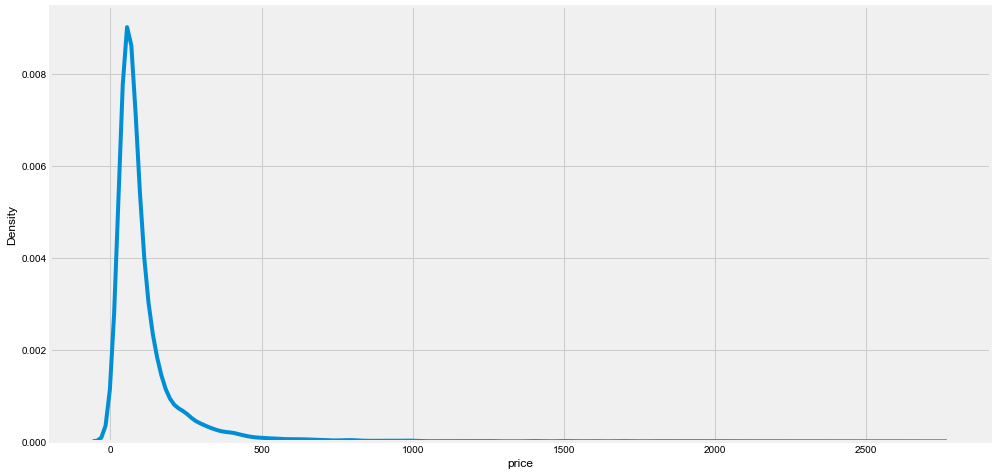

In [92]:
# Just logging the dependent variable
sns.kdeplot(price)



<AxesSubplot:xlabel='price', ylabel='Density'>

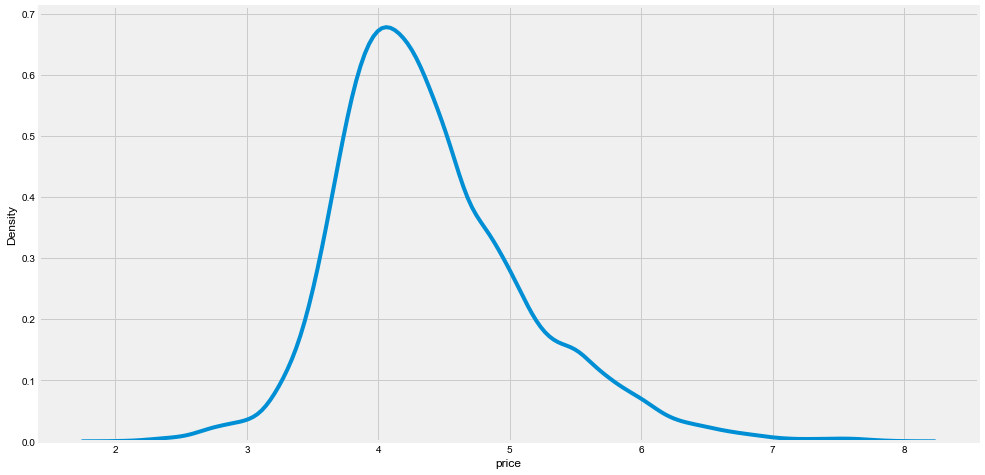

In [198]:
l_price = np.log(price)
sns.kdeplot(l_price)

In [185]:
X, y = df_5.values, l_price.values
X_train, X_test, y_train, y_test = train_test_split(df_5, l_price, test_size = 0.2, random_state = 42)

In [95]:
# from sklearn.datasets import make_blobs
# from sklearn.cluster import KMeans

In [96]:
# kmeans = KMeans(180)
# kmeans.fit(X)

In [97]:
# y_pred = kmeans.predict(X)
# plt.scatter(X[:, 0], X[:, 1], c = y_pred, s=50)

In [186]:
def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [0.1, 0.3],
                'selection': ['random', 'cyclic']
            }
        },
        'ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [0.7, 0.9]
            }
        },
        'random_forest': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [300, 500, 600], 'max_depth': [20, 25], 
            }
        },
        'xgboost': {
            'model': XGBRegressor(),
            'params': {
                'n_estimators': [100, 150], 
            }
        }

    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X, y)

,model,best_score,best_params
0,linear_regression,0.836080,{'normalize': True}
1,lasso,0.805685,"{'alpha': 0.1, 'selection': 'cyclic'}"
2,ridge,0.836077,{'alpha': 0.7}
3,random_forest,0.885462,"{'max_depth': 20, 'n_estimators': 600}"
4,xgboost,0.881005,{'n_estimators': 100}


In [192]:
lasso_reg = Lasso(alpha = 0.1, selection='cyclic')
lasso_reg.fit(X, y)
lasso_reg.score(X, y)

0.8039234610267298

In [193]:
column_labels = df_5.columns.tolist()
coef = lasso_reg.coef_.squeeze().tolist()

# Zip together
labels_coef = list(zip(column_labels, coef))

# Verify the result
print(labels_coef)

[('area_type', 0.0), ('bath', 0.06189377328499694), ('balcony', 0.0), ('total_sqft', 0.0), ('interaction', 0.17793480427730507), ('room_count', 0.0), ('dist', -0.0), ('loc_lat', 0.0), ('loc_long', -0.0), ('estimated_price', 0.3674670463863412), ('availability', 0.0), ('north', 0.0), ('north east', 0.0), ('north west', 0.0), ('south', 0.0), ('south east', -0.0), ('south west', -0.0), ('west', 0.0)]


In [194]:
valid_list_of_columns = []
for label_coeff in labels_coef:
    label = label_coeff[0]
    coeff = label_coeff[1]
    if np.abs(coeff) == 0:
        pass
    else:
        valid_list_of_columns.append(label)
valid_list_of_columns

['bath', 'interaction', 'estimated_price']

In [199]:
X, y = df_5[valid_list_of_columns].values, l_price.values
X_train, X_test, y_train, y_test = train_test_split(df_5[valid_list_of_columns], l_price, test_size = 0.33, random_state = 42) 

In [200]:
lasso_reg = Lasso(alpha = 0.1, selection='cyclic')
lasso_reg.fit(X, y)
lasso_reg.score(X, y)

0.8039254144361857

<AxesSubplot:ylabel='Density'>

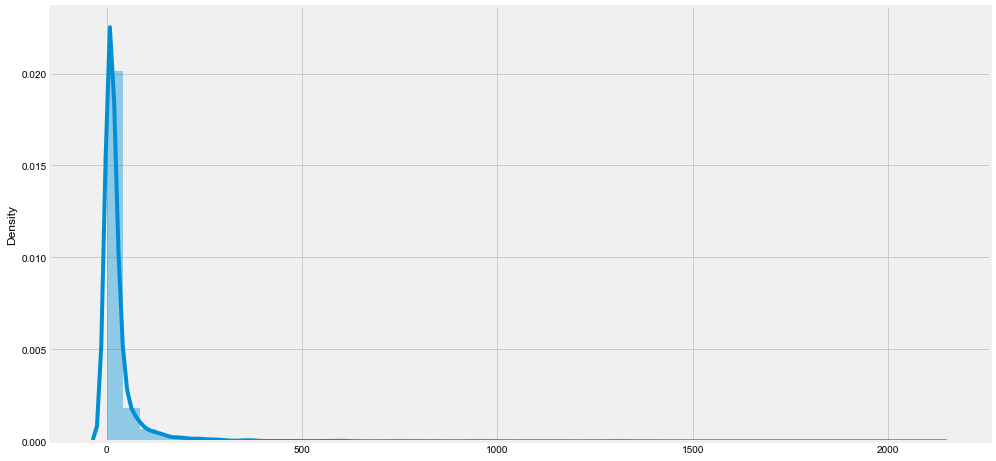

In [201]:
y_pred = np.exp(lasso_reg.predict(X))
sns.distplot(np.sqrt((y_pred-np.exp(y))**2))

In [202]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.score(X, y)

0.8286886171274711

<AxesSubplot:ylabel='Density'>

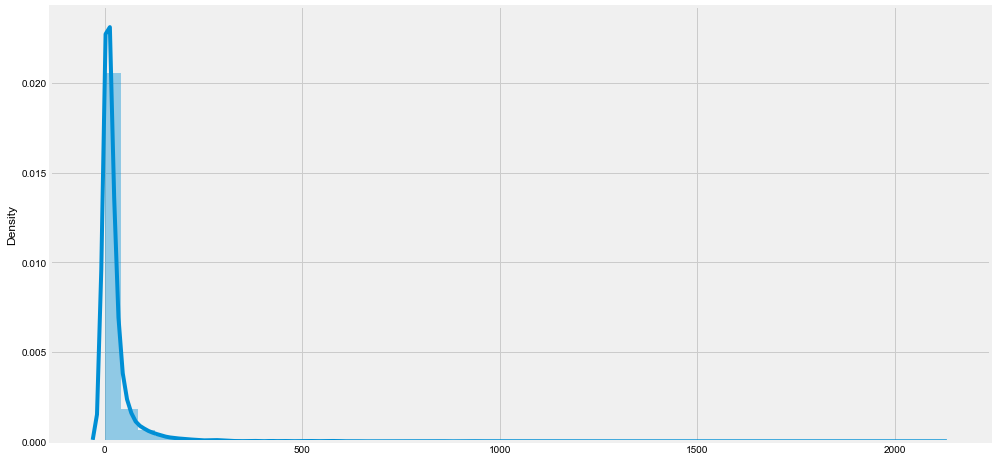

In [203]:
y_pred = np.exp(lin_reg.predict(X))
sns.distplot(np.sqrt((y_pred-np.exp(y))**2))

In [204]:
ridge_reg = Ridge(alpha = 0.7)
ridge_reg.fit(X, y)
ridge_reg.score(X, y)

0.8286886112162354

<AxesSubplot:ylabel='Density'>

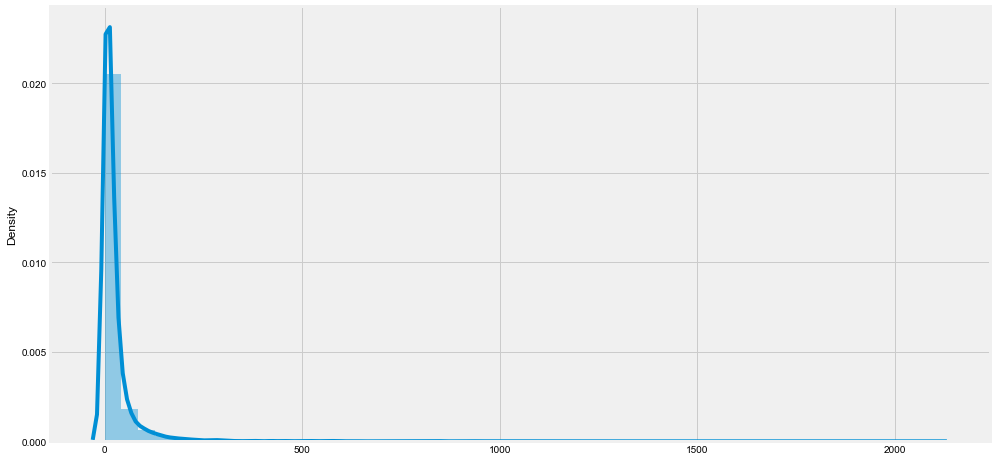

In [205]:
y_pred = np.exp(ridge_reg.predict(X))
sns.distplot(np.sqrt((y_pred-np.exp(y))**2))

In [206]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X, y)
dt_reg.score(X, y)

0.9885288945183281

<AxesSubplot:ylabel='Density'>

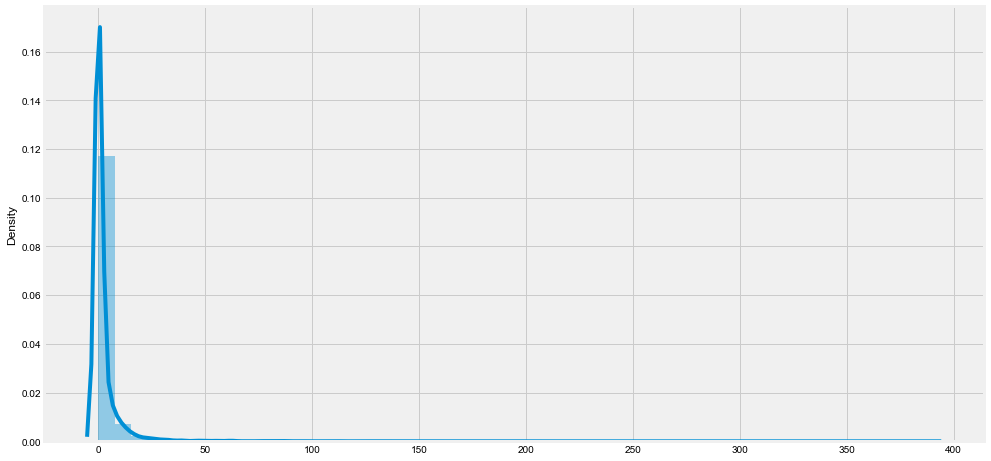

In [207]:
y_pred = np.exp(dt_reg.predict(X))
sns.distplot(np.sqrt((y_pred-np.exp(y))**2))

In [208]:
rf_reg = RandomForestRegressor(n_estimators=200, max_depth=none, criterion='mse')
rf_reg.fit(X, y)
rf_reg.score(X, y)

0.9700334070198677

<AxesSubplot:ylabel='Density'>

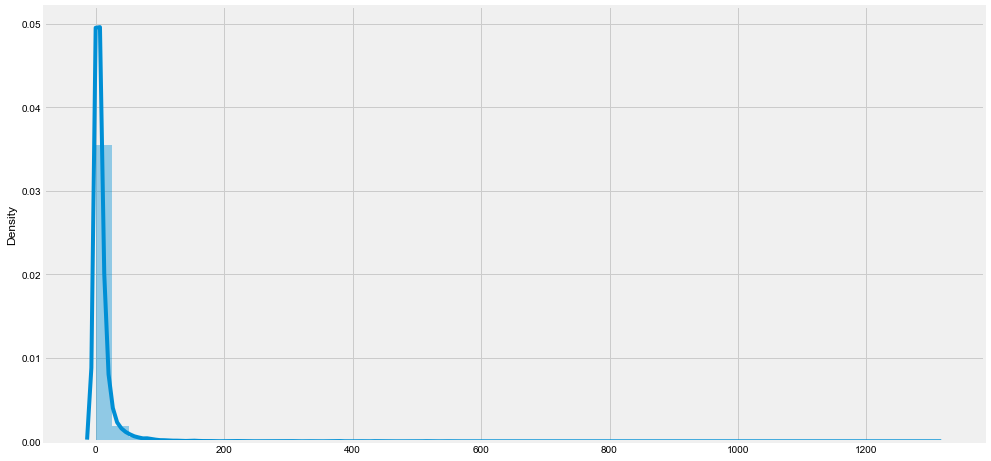

In [210]:
y_pred = np.exp(rf_reg.predict(X))
sns.distplot(np.sqrt((y_pred-np.exp(y))**2))

In [211]:
ab_reg = AdaBoostRegressor(loss = "linear")
ab_reg.fit(X, y)
ab_reg.score(X, y)

0.7592782801255382

<AxesSubplot:ylabel='Density'>

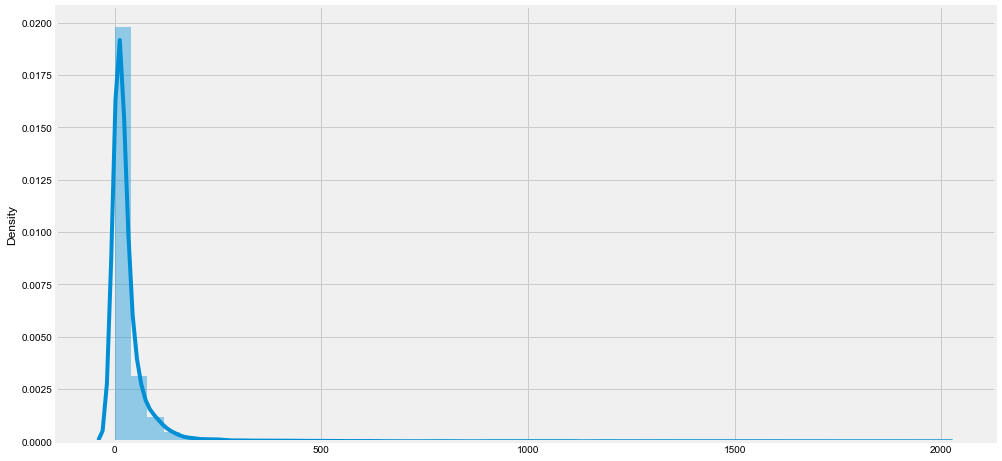

In [212]:
y_pred = np.exp(ab_reg.predict(X))
sns.distplot(np.sqrt((y_pred-np.exp(y))**2))

In [213]:
gb_reg = GradientBoostingRegressor(n_estimators=100)
gb_reg.fit(X, y)
gb_reg.score(X, y)

0.869726722576029

<AxesSubplot:ylabel='Density'>

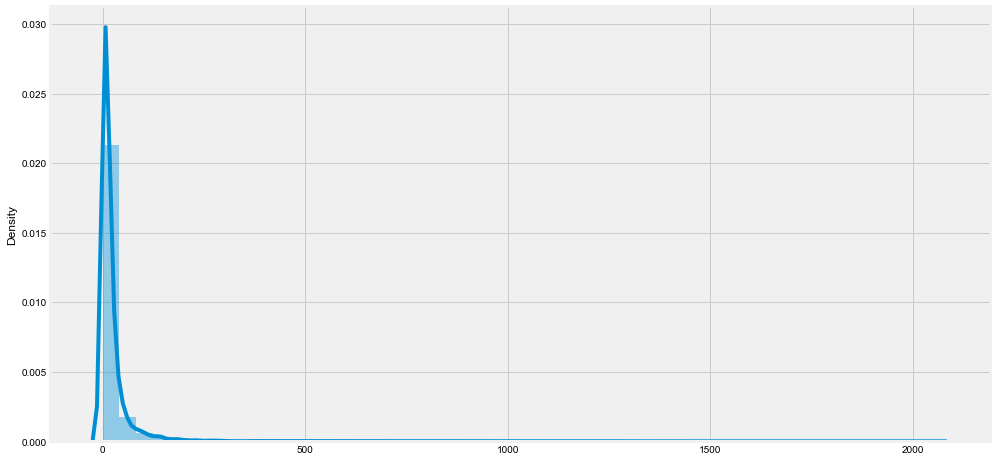

In [214]:
y_pred = np.exp(gb_reg.predict(X))
sns.distplot(np.sqrt((y_pred-np.exp(y))**2))

In [215]:
# Taking XGBRegressor as it is giving the best performance
xgb_reg = XGBRegressor(n_estimators=100)
xgb_reg.fit(X, y)
xgb_reg.score(X, y)

0.9295188268805874

<AxesSubplot:ylabel='Density'>

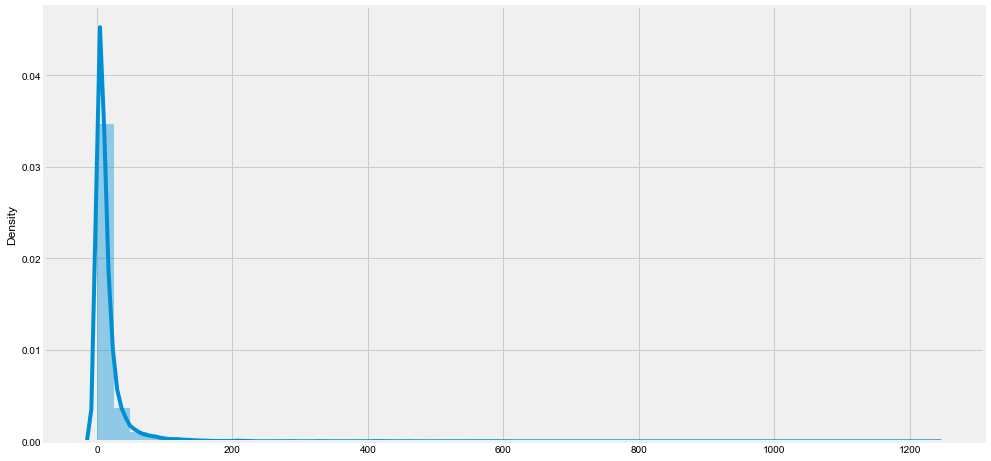

In [216]:
y_pred = np.exp(xgb_reg.predict(X))
sns.distplot(np.sqrt((y_pred-np.exp(y))**2))

In [218]:
# Trying Grid Search CV with ElasticNet
hyp_param = {'alpha':[0.002, 0.001, 0.09], 'l1_ratio':[0.999, 1, 2]}
enet = ElasticNet(normalize=True)
hyper_model = GridSearchCV(estimator=enet, param_grid=hyp_param, cv=5, scoring='r2')

enet_model = hyper_model.fit(X, y)
enet_rmse = rmse(enet_model.predict(X),y)
print(f"Best Hyper Parameter: {enet_model.best_params_}")
print(f"Best Score: {enet_model.best_score_} | RMSE: {enet_rmse}")

Best Hyper Parameter: {'alpha': 0.001, 'l1_ratio': 1}
Best Score: 0.8056634348597476 | RMSE: 0.3214058863436886


<AxesSubplot:ylabel='Density'>

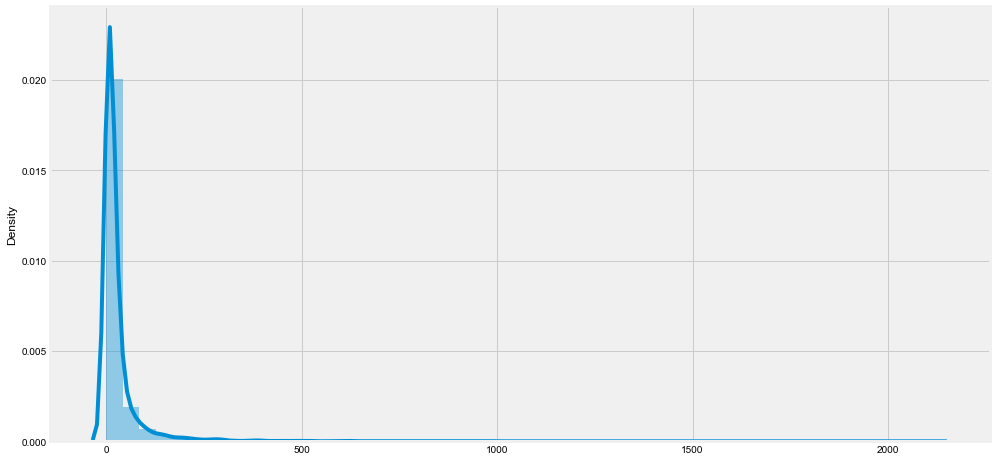

In [219]:
y_pred = np.exp(enet_model.predict(X))
sns.distplot(np.sqrt((y_pred-np.exp(y))**2))

In [220]:
from sklearn.ensemble import HistGradientBoostingRegressor

est = HistGradientBoostingRegressor().fit(X, y)
y_pred = np.exp(est.predict(X))
rmse_hgbr = rmse(y_pred, y)
print(est.score(X, y), rmse_hgbr)

0.8840437808159294 157.37805116337134


<AxesSubplot:ylabel='Density'>

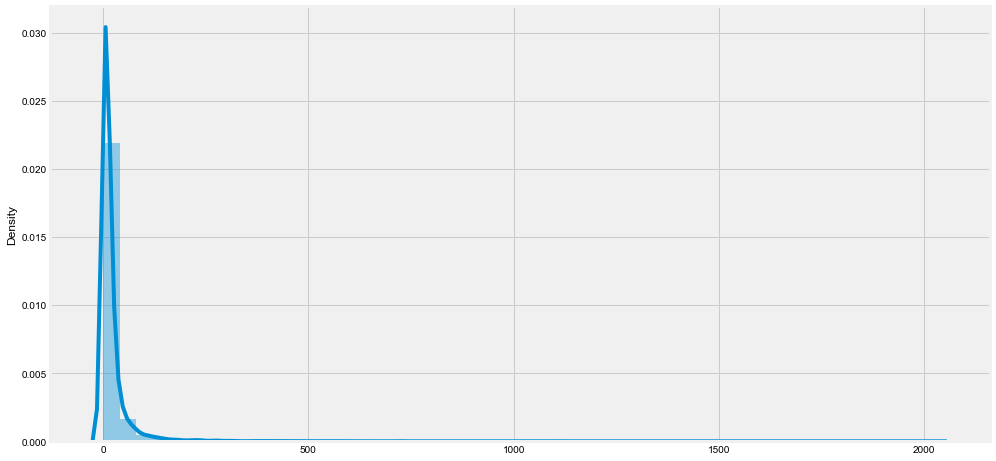

In [221]:
y_pred = np.exp(est.predict(X))
sns.distplot(np.sqrt((y_pred-np.exp(y))**2))

In [124]:
#! pip install vecstack

In [125]:
# ! pip install lightgbm

In [222]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

xgb = XGBRegressor()
dt = DecisionTreeRegressor()
lgbm = LGBMRegressor()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
lasso = Lasso()
svr = SVR(kernel='linear')

stack = StackingCVRegressor(regressors=(rf,gb,xgb),
                            meta_regressor=xgb, cv=4,
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=False,
                            random_state=42)

stack.fit(X, y)

StackingCVRegressor(cv=4,
                    meta_regressor=XGBRegressor(base_score=None, booster=None,
                                                callbacks=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=None,
                                                early_stopping_rounds=None,
                                                enable_categorical=False,
                                                eval_metric=None, gamma=None,
                                                gpu_id=None, grow_policy=None,
                                                importance_type=None,
                                                interaction_constraints=None,
                                                learning_rate=None,
                                                max_bin=...
                                  

In [223]:
pred = np.exp(stack.predict(X_test))
score = r2_score(np.exp(y_test), pred)
score

0.8504317691587617

<AxesSubplot:xlabel='price', ylabel='Density'>

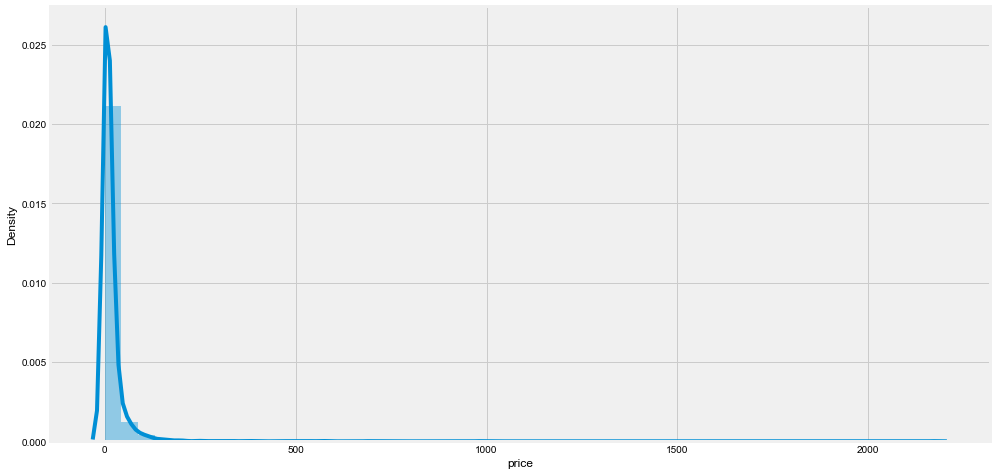

In [224]:
sns.distplot(np.sqrt((pred-np.exp(y_test))**2))

In [225]:
stack_full = StackingCVRegressor(regressors=(rf, xgb),
                            meta_regressor=xgb, cv=4, 
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=True,
                            random_state=58)

stack_full.fit(X, y)

StackingCVRegressor(cv=4,
                    meta_regressor=XGBRegressor(base_score=None, booster=None,
                                                callbacks=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=None,
                                                early_stopping_rounds=None,
                                                enable_categorical=False,
                                                eval_metric=None, gamma=None,
                                                gpu_id=None, grow_policy=None,
                                                importance_type=None,
                                                interaction_constraints=None,
                                                learning_rate=None,
                                                max_bin=...
                                  

In [226]:
pred = np.exp(stack_full.predict(X))
score = r2_score(np.exp(y), pred)
score

0.871789358321227

<AxesSubplot:ylabel='Density'>

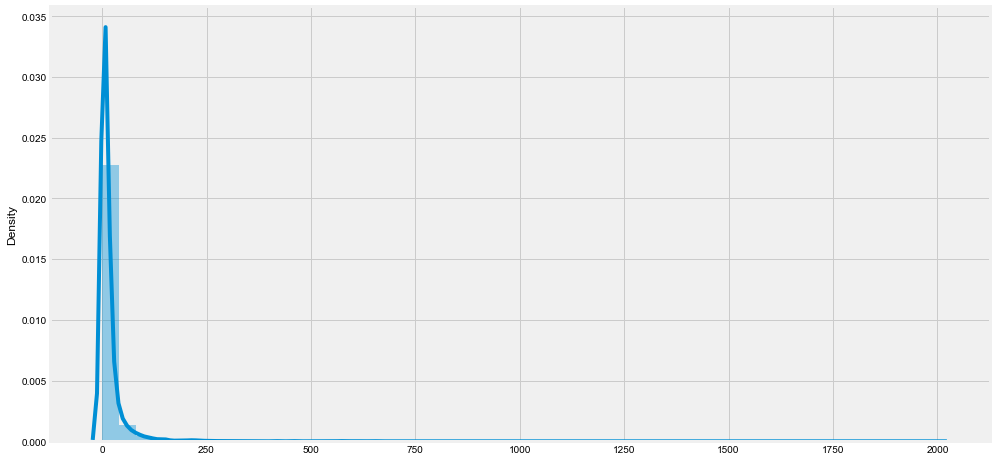

In [227]:
sns.distplot(np.sqrt((pred-np.exp(y))**2))

## PROCESSING THE TEST-DATA

In [228]:
df_test.head()

,Unnamed: 0,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,loc_lat,loc_long,dir_from_centre
0,0,0,Super built-up Area,1,chamrajpet,2 BHK,NaN,650,1.0,1.0,12.956997,77.563368,south west
1,1,1,Super built-up Area,1,7th phase jp nagar,3 BHK,SrncyRe,1370,2.0,1.0,12.912432,77.575952,south
2,2,2,Super built-up Area,1,whitefield,3 BHK,AjhalNa,1725,3.0,2.0,12.969637,77.749745,east
3,3,3,Built-up Area,1,jalahalli,2 BHK,NaN,1000,2.0,0.0,13.046453,77.548380,north west
4,4,4,Plot Area,1,tc palaya,1 Bedroom,NaN,1350,1.0,0.0,13.009855,77.693089,east


In [229]:
df_test['availability'] = df_test['availability'].apply(lambda x: 1 if x=="Ready To Move" else 0)

In [230]:
df_test_1 = df_test.drop(columns=["ID", "society", "Unnamed: 0"])
df_test_1.isna().sum()

area_type            0
availability         0
location             0
size                 2
total_sqft           0
bath                 8
balcony            105
loc_lat              4
loc_long             4
dir_from_centre      4
dtype: int64

In [231]:
df_test_1['location'] = df_test_1['location'].fillna('whitefield')

In [232]:
df_test_1['size'] = df_test_1['size'].fillna('2 BHK')

# Creating 3 additional columns
df_test_1['hall'] = np.nan
df_test_1['kitchen'] = np.nan
df_test_1['room_count'] = np.nan

for index, row in df_test_1.iterrows():
    split_size(df_test_1, index, df_test_1.loc[index, 'size'])
    
df_test_1[['room_count']] = df_test_1[['room_count']].astype(float)    

In [233]:
df_test_1.isna().sum()

area_type            0
availability         0
location             0
size                 0
total_sqft           0
bath                 8
balcony            105
loc_lat              4
loc_long             4
dir_from_centre      4
hall                 0
kitchen              0
room_count           0
dtype: int64

In [234]:
# Getting rid of all NaN from latitude column
df_test_1[df_test_1['loc_lat'].isna()]

,area_type,availability,location,size,total_sqft,bath,balcony,loc_lat,loc_long,dir_from_centre,hall,kitchen,room_count
998,Super built-up Area,0,javarandoddi,1 BHK,648,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0
1123,Built-up Area,0,devasthanagalu,3 BHK,1470,2.0,3.0,NaN,NaN,NaN,1.0,1.0,3.0
1438,Built-up Area,0,volagerekallahalli,2 BHK,1095,2.0,1.0,NaN,NaN,NaN,1.0,1.0,2.0
1974,Super built-up Area,0,devasthanagalu,2 BHK,1057,2.0,1.0,NaN,NaN,NaN,1.0,1.0,2.0


In [235]:
# Getting rid of all NaN from longitude column
df_test_1[df_test_1['loc_long'].isna()]

,area_type,availability,location,size,total_sqft,bath,balcony,loc_lat,loc_long,dir_from_centre,hall,kitchen,room_count
998,Super built-up Area,0,javarandoddi,1 BHK,648,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0
1123,Built-up Area,0,devasthanagalu,3 BHK,1470,2.0,3.0,NaN,NaN,NaN,1.0,1.0,3.0
1438,Built-up Area,0,volagerekallahalli,2 BHK,1095,2.0,1.0,NaN,NaN,NaN,1.0,1.0,2.0
1974,Super built-up Area,0,devasthanagalu,2 BHK,1057,2.0,1.0,NaN,NaN,NaN,1.0,1.0,2.0


In [236]:
# Mapping the relatively known areas for those areas whose geocodes is not known
# devasthanagalu : varthur
# javarandoddi : rr nagar
# volagerekallahalli : Chikkadasarahalli
# dominic layout : Kodigehalli
# cooketown : banaswadi
# devasandra extension : kr puram
# bsm extension : kengeri
# chuchangatta colony : patel narayanappa layout
# havanur extension : nagasandra
df_test_1.loc[(df_test_1['location']=="javarandoddi"), 'loc_lat'] = get_geocode("rr nagar").split("-")[0]
df_test_1.loc[(df_test_1['location']=="javarandoddi"), 'loc_long'] = get_geocode("rr nagar").split("-")[1]
df_test_1.loc[(df_test_1['location']=="javarandoddi"), 'dir_from_centre']=get_direction_from_city_centre(get_geocode("rr nagar"))
df_test_1.loc[(df_test_1['location']=="devasthanagalu"),'loc_lat'] = get_geocode("varthur").split("-")[0]
df_test_1.loc[(df_test_1['location']=="devasthanagalu"),'loc_long'] = get_geocode("varthur").split("-")[1]
df_test_1.loc[(df_test_1['location']=="devasthanagalu"), 'dir_from_centre']=get_direction_from_city_centre(get_geocode("varthur"))
df_test_1.loc[(df_test_1['location']=="volagerekallahalli"),'loc_lat'] = get_geocode("chikkadasarahalli").split("-")[0]
df_test_1.loc[(df_test_1['location']=="volagerekallahalli"),'loc_long'] = get_geocode("chikkadasarahalli").split("-")[1]
df_test_1.loc[(df_test_1['location']=="volagerekallahalli"), 'dir_from_centre']=get_direction_from_city_centre(get_geocode("chikkadasarahalli"))
# df_test_1.loc[(df_test_1['location']=="dominic layout"),'loc_lat'] = get_geocode("kodigehalli").split("-")[0]
# df_test_1.loc[(df_test_1['location']=="cooketown"),'loc_long'] = get_geocode("banaswadi").split("-")[1]
# df_test_1.loc[(df_test_1['location']=="devasandra extension"),'loc_long'] = get_geocode("kr puram").split("-")[1]
# df_test_1.loc[(df_test_1['location']=="bsm extension"),'loc_long'] = get_geocode("kengeri").split("-")[1]
# df_test_1.loc[(df_test_1['location']=="chuchangatta colony"),'loc_long'] = get_geocode("patel narayanappa layout").split("-")[1]
# df_test_1.loc[(df_test_1['location']=="havanur extension"),'loc_long'] = get_geocode("nagasandra").split("-")[1]

rr nagar
rr nagar
rr nagar
12.9331339-77.5298694
varthur
varthur
varthur
12.9406152-77.7469937
chikkadasarahalli
chikkadasarahalli
chikkadasarahalli
13.602110000000039-76.93465000000003


<AxesSubplot:xlabel='room_count', ylabel='bath'>

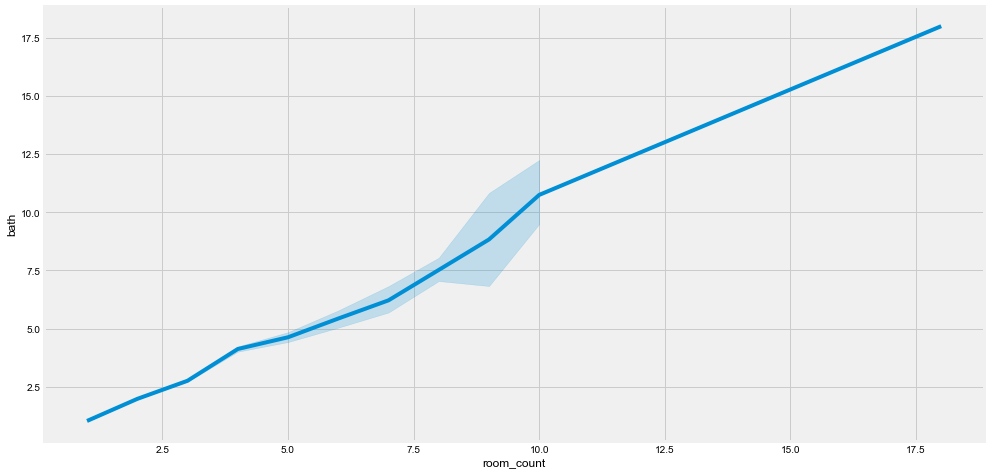

In [237]:
# Trying to find if room_count and number of bathrooms are linearly correlated
sns.lineplot(x=df_test_1['room_count'], y=df_test_1['bath'])

In [238]:
# Filling the NaN values in bath with corresponding median for the respective room size from median_bath_df
for index, row in df_test_1.iterrows():
    if np.isnan(df_test_1.loc[index, 'bath']):
        df_test_1.loc[index, 'bath'] = median_bath_df.loc[df_test_1.loc[index,'room_count']].values[0]


In [239]:
# Filling NaN values with corresponding mean for the respective room size
for index, row in df_test_1.iterrows():
    if np.isnan(df_test_1.loc[index, 'balcony']):
        if df_test_1.loc[index,'size'] in balcony_df.index:
            df_test_1.loc[index, 'balcony'] = balcony_df.loc[df_test_1.loc[index,'room_count']].values[0]
        else:
            df_test_1.loc[index, 'balcony'] = 0

In [240]:
df_test_1.head()

,area_type,availability,location,size,total_sqft,bath,balcony,loc_lat,loc_long,dir_from_centre,hall,kitchen,room_count
0,Super built-up Area,0,chamrajpet,2 BHK,650,1.0,1.0,12.956997,77.563368,south west,1.0,1.0,2.0
1,Super built-up Area,0,7th phase jp nagar,3 BHK,1370,2.0,1.0,12.912432,77.575952,south,1.0,1.0,3.0
2,Super built-up Area,0,whitefield,3 BHK,1725,3.0,2.0,12.969637,77.749745,east,1.0,1.0,3.0
3,Built-up Area,0,jalahalli,2 BHK,1000,2.0,0.0,13.046453,77.54838,north west,1.0,1.0,2.0
4,Plot Area,0,tc palaya,1 Bedroom,1350,1.0,0.0,13.009855,77.693089,east,0.0,0.0,1.0


In [241]:
df_test_1["total_sqft"] = df_test_1["total_sqft"].apply(units_in_sq_ft)

In [242]:
df_test_1.isna().sum()

area_type          0
availability       0
location           0
size               0
total_sqft         0
bath               0
balcony            0
loc_lat            0
loc_long           0
dir_from_centre    0
hall               0
kitchen            0
room_count         0
dtype: int64

In [243]:
df_test_1[['total_sqft','room_count']] = df_test_1[['total_sqft','room_count']].astype(float)

In [244]:
df_test_1["sqft_per_bhk"] = df_test_1['total_sqft']/df_test_1['room_count']

In [245]:
# NOT CREATING THIS ADDITIONAL COLUMN
# df_test_1['room_size'] = np.nan

# for index, row in df_test_1.iterrows():
#     if df_test_1.loc[index,'total_sqft']/df_test_1.loc[index,'room_count'] < 300:
#         df_test_1.loc[index, 'room_size'] = 0
#     else:
#         df_test_1.loc[index, 'room_size'] = 1

In [246]:
df_test_1['dist'] = df_test_1['location'].apply(get_dist)
df_test_1.head()

shanthi pura
shanthi pura - 12.846060000000023 | 77.68448000000006
viviani road
viviani road - 13.003334813655497 | 77.61647769283225
sampangirama nagar
sampangirama nagar - 12.977170000000058 | 77.58973000000003
doctor layout rayasandra
doctor layout rayasandra - 12.87411000000003 | 77.67486000000008
anwar layout
anwar layout - 13.019900000000064 | 77.61776000000003
pillanna gardens
pillanna gardens - 13.011490000000038 | 77.61828000000008
ullal uppanagar
ullal uppanagar - 12.95619000000005 | 77.48006000000004
aecs layout a-block singasandra
aecs layout a-block singasandra - 12.885730000000024 | 77.64489000000003
banashankari stage i
banashankari stage i - 12.938740000000053 | 77.55508000000003
anjappa layout
anjappa layout - 12.910380000000032 | 77.55334000000005
himagiri meadows
himagiri meadows - 12.860770000000059 | 77.59295000000003
4th block hbr layout
4th block hbr layout - 13.031180000000063 | 77.63184000000007
basava nagar
basava nagar - 12.969610000000046 | 77.68237000000005

kashi nagar - 12.898790000000076 | 77.56916000000007
nanjappa garden
nanjappa garden - 12.957200000000057 | 77.61904000000004
allalasandra
allalasandra - 13.085440000000062 | 77.58919000000003
anjappa layout
anjappa layout - 12.910380000000032 | 77.55334000000005
chikkakannalli
chikkakannalli - 12.896660000000054 | 77.69607000000008
aishwarya crystal layout
aishwarya crystal layout - 12.92049000000003 | 77.51417000000004
ramanagara channapatna
ramanagara channapatna - 12.649180000000058 | 77.20958000000007
maheswari nagar
maheswari nagar - 12.99490000000003 | 77.69141000000008
kamakya layout
kamakya layout - 12.921430000000043 | 77.55472000000003
hsr layout sector3
hsr layout sector3 - 12.910750000000064 | 77.64170000000007
thyagraj nagar
thyagraj nagar - 12.932330000000036 | 77.56985000000003
kothnoor dinne
kothnoor dinne - 12.881062198957205 | 77.57592595818322
chikka banaswadi
chikka banaswadi - 13.007820000000038 | 77.64730000000003
banagirinagar
banagirinagar - 12.923400000000072 

kanakapura main road - 12.799940059949156 | 77.54026202604167
b channasandra
b channasandra - 13.008980000000065 | 77.66059000000007
srinagar
srinagar - 12.944570000000056 | 77.55290000000008
virupakshapura
virupakshapura - 13.066470000000038 | 77.57024000000007
bhagyalakshmi avenue
bhagyalakshmi avenue - 12.87841000000003 | 77.61404000000005
masjid e alkareem
masjid e alkareem - 13.031420000000026 | 77.61529000000007
kavika layout
kavika layout - 12.953350000000057 | 77.53724000000005
8th block jayanagar
8th block jayanagar - 12.920530000000042 | 77.57792000000006
sathya layout
sathya layout - 12.89626000000004 | 77.61548000000005
smv layout
smv layout - 12.97446499949995 | 77.63163999544065
agrahara dasarahalli
agrahara dasarahalli - 12.981900000000053 | 77.53761000000003
keb colony
keb colony - 12.930766390184601 | 77.55409731591726
chikku lakshmaiah layout
chikku lakshmaiah layout - 12.936310000000049 | 77.60825000000006
sri balaji krupa layout
sri balaji krupa layout - 12.87528000

,area_type,availability,location,size,total_sqft,bath,balcony,loc_lat,loc_long,dir_from_centre,hall,kitchen,room_count,sqft_per_bhk,dist
0,Super built-up Area,0,chamrajpet,2 BHK,650.0,1.0,1.0,12.956997,77.563368,south west,1.0,1.0,2.0,325.000000,6.7
1,Super built-up Area,0,7th phase jp nagar,3 BHK,1370.0,2.0,1.0,12.912432,77.575952,south,1.0,1.0,3.0,456.666667,11.0
2,Super built-up Area,0,whitefield,3 BHK,1725.0,3.0,2.0,12.969637,77.749745,east,1.0,1.0,3.0,575.000000,17.3
3,Built-up Area,0,jalahalli,2 BHK,1000.0,2.0,0.0,13.046453,77.54838,north west,1.0,1.0,2.0,500.000000,16.6
4,Plot Area,0,tc palaya,1 Bedroom,1350.0,1.0,0.0,13.009855,77.693089,east,0.0,0.0,1.0,1350.000000,12.2


In [247]:
# Dropping columns for later
df_test_1.drop(columns=["size"], inplace=True)
# df_test_1["location"] = df_test_1["location"].apply(lambda x : "other" if (x in unique_location_count_10) or (x not in set_location_in_both_train_test_data) else x)

In [248]:
df_test_1[["loc_lat", "loc_long"]] = df_test_1[["loc_lat","loc_long"]].astype(float)

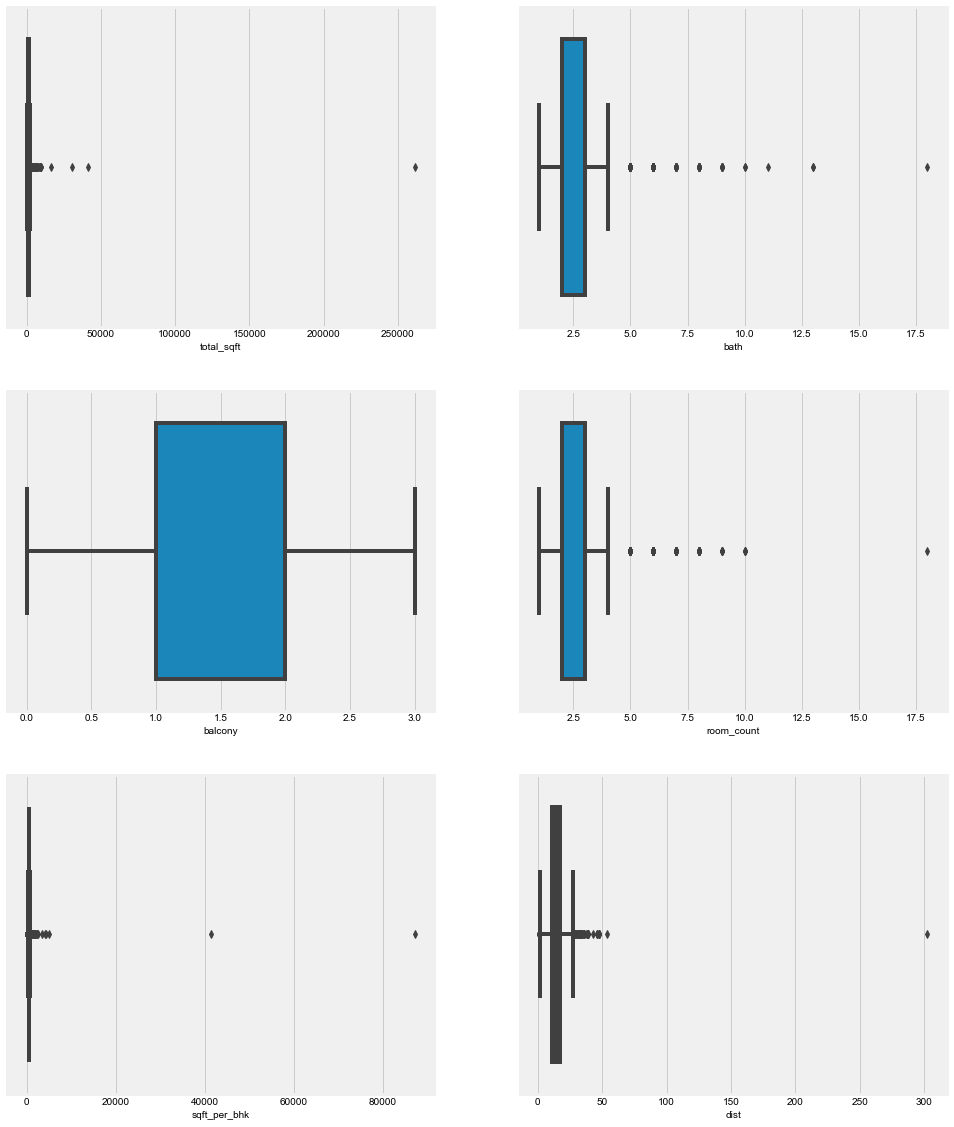

In [249]:
from matplotlib import pyplot as plt

df_num = df_test_1.select_dtypes(include=np.number)
# Dropping the categorical columns which are only numerically encoded
df_num.drop(columns=["availability","hall","kitchen","loc_lat","loc_long"], inplace=True)
fig,ax = plt.subplots(3,2, figsize=(15,20))

for col, sub in zip(df_num, ax.flatten()):
    z=sns.boxplot(x=df_num[col], ax=sub, orient='h')
    z.set_xlabel(col, fontsize=10)

In [250]:
# Getting rid of the outliers from originally numeric column
# for col in df_num.columns:
#     tempdata = df_num[col]
#     q1,q3 = tempdata.quantile([0.25,0.75])
#     IQR = q3-q1
#     print(col, q1,q3, IQR)
#     lr = q1-1.5*IQR
#     ur = q3+1.5*IQR
#     # Replacing the values 
#     df_num[col] = df_num[col].apply(lambda x: x if x <= ur else ur)
#     df_num[col] = df_num[col].apply(lambda x: x if x >= lr else lr)


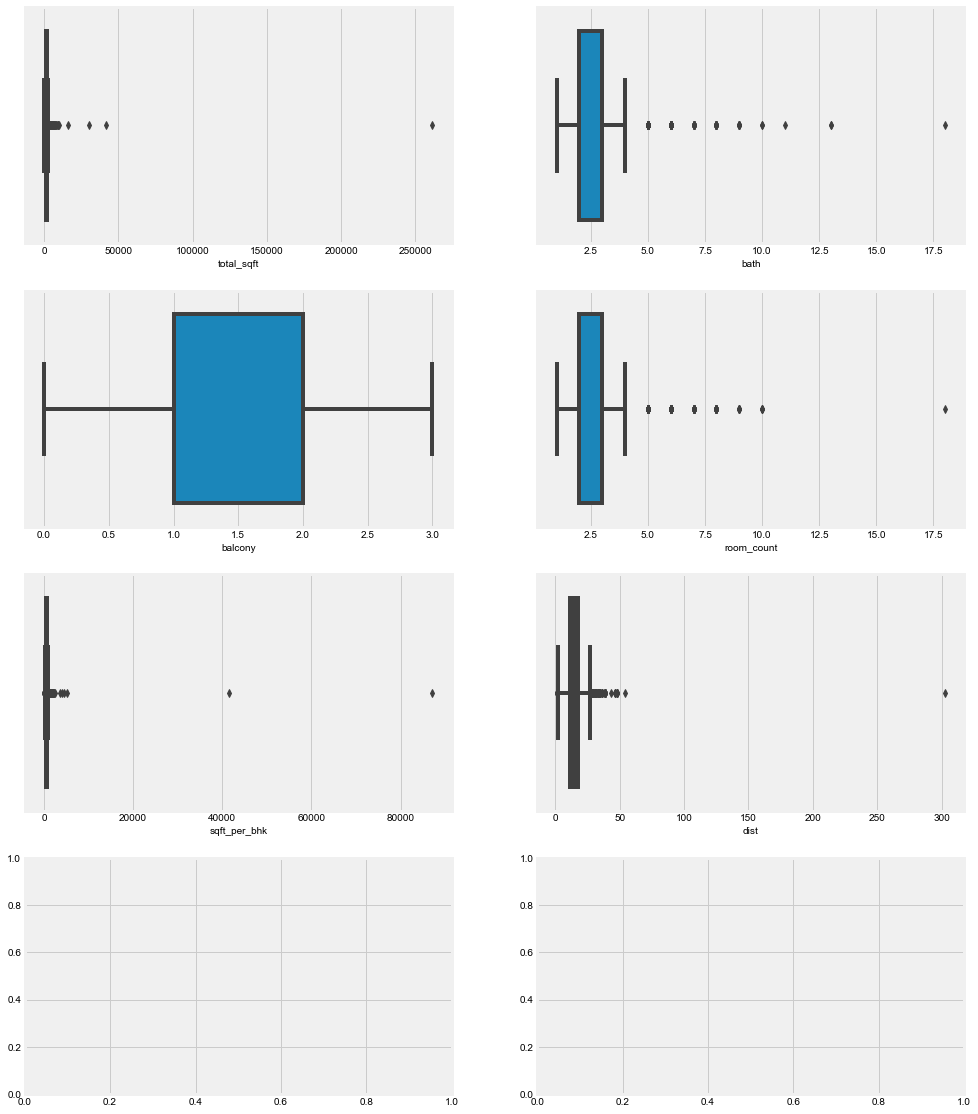

In [251]:
fig,ax = plt.subplots(4,2, figsize=(15,20))

for col, sub in zip(df_num, ax.flatten()):
    z=sns.boxplot(x=df_num[col], ax=sub, orient='h')
    z.set_xlabel(col, fontsize=10)

In [252]:
df_test_2 = pd.concat([df_test_1.drop(columns=df_num.columns), df_num], axis=1)
print(df_test_2.shape)
df_test_2.head()

(2664, 14)


,area_type,availability,location,loc_lat,loc_long,dir_from_centre,hall,kitchen,total_sqft,bath,balcony,room_count,sqft_per_bhk,dist
0,Super built-up Area,0,chamrajpet,12.956997,77.563368,south west,1.0,1.0,650.0,1.0,1.0,2.0,325.000000,6.7
1,Super built-up Area,0,7th phase jp nagar,12.912432,77.575952,south,1.0,1.0,1370.0,2.0,1.0,3.0,456.666667,11.0
2,Super built-up Area,0,whitefield,12.969637,77.749745,east,1.0,1.0,1725.0,3.0,2.0,3.0,575.000000,17.3
3,Built-up Area,0,jalahalli,13.046453,77.548380,north west,1.0,1.0,1000.0,2.0,0.0,2.0,500.000000,16.6
4,Plot Area,0,tc palaya,13.009855,77.693089,east,0.0,0.0,1350.0,1.0,0.0,1.0,1350.000000,12.2


In [253]:
# Ordinal Encoding to area_type
df_test_2['area_type'] = df_test_2['area_type'].map(ordinal_encoding_area_dict)

In [254]:
# Get Unique location and it's coordinates
list_loc_lat_long = []
df_loc_coordinates = df_3.drop_duplicates('location')[['location', 'loc_lat', 'loc_long']].reset_index(drop=True)
df_loc_coordinates.head()

,location,loc_lat,loc_long
0,electronic city phase ii,12.846854,77.676927
1,chikka tirupathi,12.895768,77.867101
2,uttarahalli,12.905568,77.545544
3,lingadheeranahalli,13.001290,77.479070
4,kothanur,13.061360,77.649389


In [255]:
# Get average price for number of rooms in train data
df_room_wise_avg = pd.DataFrame(df.groupby('room_count')['price'].agg('mean'))
df_room_wise_avg

,price
room_count,
1.0,44.898662
2.0,59.804524
3.0,111.058933
4.0,271.044855
5.0,282.452128
6.0,203.885714
7.0,260.350649
8.0,207.573529
9.0,254.375000


In [256]:
# Hardcoding the room_count for an edge case only when outliers are not removed
df_test_2.loc[903, 'room_count'] = 10

In [257]:
from sklearn.neighbors import NearestNeighbors
from scipy import spatial

def get_estimated_price_for_test_data(test_df):
    unique_test_location = df_test_2['location'].unique()
    unique_loc_in_train = df_avg_price_for_aroom_in_any_location.index.get_level_values(0).unique()
    
    # Getting the list of coordinates
    loc_lat_long_train = []
    for all_val in df_loc_coordinates.values:
        loc_lat_long_train.append((all_val[1], all_val[2]))
    
    tree = spatial.KDTree(loc_lat_long_train)
    # First fill up the estimated price for all locations in test data which are available in train data
    for index, row in test_df.iterrows():
        loc = test_df.loc[index,"location"]
        rc = math.ceil(test_df.loc[index, "room_count"])
        # Check if the response of the query is from avg_price from train data is found or not.
        if df_avg_price_for_aroom_in_any_location.query('location==@loc and room_count==@rc').empty:
            test_loc_lat = test_df.loc[index,"loc_lat"]
            test_loc_long = test_df.loc[index,"loc_long"]
            # Using KD Tree to find 5 nearest neighbours:
            loc_lat_long_test = [(test_loc_lat, test_loc_long)]
            idxs = tree.query(loc_lat_long_test,5)
            # idxs is the set of indexes of df_loc_coordinates which is closeby
            
            list_of_room_prices = []
            for idx in idxs[1][0]:  
         
                # Get the neighbour location
                neighbour_loc = df_loc_coordinates.loc[idx,'location']
                # Get the price for the location and room and add it to the list
                if df_avg_price_for_aroom_in_any_location.query('location==@neighbour_loc and room_count==@rc').empty:
                    continue
                else:
                    list_of_room_prices.append(df_avg_price_for_aroom_in_any_location.query('location==@neighbour_loc and room_count==@rc').values[0][0])
            
            list_of_room_prices.sort()
            
            # If rooms not found for the given location - Take the average price calculated for each room type
            if len(list_of_room_prices) == 0:
                test_df.loc[index, 'estimated_price'] = df_room_wise_avg.loc[rc].values[0]
            else:
                # Take the price from the list
                test_df.loc[index, 'estimated_price'] = list_of_room_prices[math.ceil(len(list_of_room_prices)//2)]
        else:
            test_df.loc[index, 'estimated_price'] = df_avg_price_for_aroom_in_any_location.query('location==@loc and room_count==@rc').values[0][0]        
    return test_df   

In [258]:
# Get Estimated price for Test-Data as well
df_test_2['estimated_price'] = ""
df_test_3 = get_estimated_price_for_test_data(df_test_2)
df_test_3['estimated_price'] = df_test_3['estimated_price'].astype(float)
df_test_3.head()

,area_type,availability,location,loc_lat,loc_long,dir_from_centre,hall,kitchen,total_sqft,bath,balcony,room_count,sqft_per_bhk,dist,estimated_price
0,3,0,chamrajpet,12.956997,77.563368,south west,1.0,1.0,650.0,1.0,1.0,2.0,325.000000,6.7,162.0
1,3,0,7th phase jp nagar,12.912432,77.575952,south,1.0,1.0,1370.0,2.0,1.0,3.0,456.666667,11.0,110.0
2,3,0,whitefield,12.969637,77.749745,east,1.0,1.0,1725.0,3.0,2.0,3.0,575.000000,17.3,91.0
3,2,0,jalahalli,13.046453,77.548380,north west,1.0,1.0,1000.0,2.0,0.0,2.0,500.000000,16.6,58.0
4,4,0,tc palaya,13.009855,77.693089,east,0.0,0.0,1350.0,1.0,0.0,1.0,1350.000000,12.2,200.0


In [259]:
# Adding the interaction column from above
df_test_3['interaction'] = df_test_3['total_sqft'] * df_test_3['sqft_per_bhk'] * df_test_3['estimated_price']

In [260]:
# Dropping sqft_per_bhk as it will any way get dropped with lasso
df_test_3.drop(columns=['sqft_per_bhk'], inplace=True)

In [261]:
h_num = df_test_3[['area_type','bath', 'balcony', 'total_sqft', 'interaction', 'room_count', 'dist', 'loc_lat', 'loc_long', 'estimated_price']].reset_index(drop=True)

# Log transformation of columns: loc_lat loc_long total_sqft dist estimated_price interaction
h_num['total_sqft'] = np.log(h_num['total_sqft'])
h_num['estimated_price'] = np.log(h_num['estimated_price'])
h_num['interaction'] = np.log(h_num['interaction'])

In [262]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()
min_max_scaler=preprocessing.MinMaxScaler()
scaled_f = pd.DataFrame(rob_scaler.fit_transform(h_num), columns=h_num.columns)
scaled_f.head()

,area_type,bath,balcony,total_sqft,interaction,room_count,dist,loc_lat,loc_long,estimated_price
0,0.0,-1.0,-1.0,-1.659968,-0.302623,-1.0,-1.187500,-0.059153,-0.677984,1.108307
1,0.0,0.0,-1.0,0.145717,0.298793,0.0,-0.515625,-0.429320,-0.557072,0.588202
2,0.0,1.0,0.0,0.703740,0.532273,0.0,0.468750,0.045838,1.112899,0.333439
3,-1.0,0.0,-2.0,-0.616694,-0.445173,-1.0,0.359375,0.683902,-0.822002,-0.271713
4,1.0,-1.0,-2.0,0.110101,1.733909,-2.0,-0.328125,0.379908,0.568498,1.391418


In [263]:
# h_num = df_test_3[['bath', 'balcony', 'total_sqft', 'interaction', 'room_count', 'dist', 'loc_lat', 'loc_long']].reset_index(drop=True)
# scaled_f = h_num

In [264]:
dummies = pd.get_dummies(data=df_test_3.drop(columns=['area_type', 'location', 'bath', 'balcony', 'total_sqft', 'interaction', 'room_count', 'dist', 'loc_lat', 'loc_long', 'estimated_price']), columns=["dir_from_centre"], drop_first=True, prefix='', prefix_sep='')
dummies.head()

,availability,hall,kitchen,north,north east,north west,south,south east,south west,west
0,0,1.0,1.0,0,0,0,0,0,1,0
1,0,1.0,1.0,0,0,0,1,0,0,0
2,0,1.0,1.0,0,0,0,0,0,0,0
3,0,1.0,1.0,0,0,1,0,0,0,0
4,0,0.0,0.0,0,0,0,0,0,0,0


In [265]:
df_test_4 = pd.concat([scaled_f, dummies.reset_index(drop=True)], axis=1)
print(df_test_4.shape)
df_test_4.head()

(2664, 20)


,area_type,bath,balcony,total_sqft,interaction,room_count,dist,loc_lat,loc_long,estimated_price,availability,hall,kitchen,north,north east,north west,south,south east,south west,west
0,0.0,-1.0,-1.0,-1.659968,-0.302623,-1.0,-1.187500,-0.059153,-0.677984,1.108307,0,1.0,1.0,0,0,0,0,0,1,0
1,0.0,0.0,-1.0,0.145717,0.298793,0.0,-0.515625,-0.429320,-0.557072,0.588202,0,1.0,1.0,0,0,0,1,0,0,0
2,0.0,1.0,0.0,0.703740,0.532273,0.0,0.468750,0.045838,1.112899,0.333439,0,1.0,1.0,0,0,0,0,0,0,0
3,-1.0,0.0,-2.0,-0.616694,-0.445173,-1.0,0.359375,0.683902,-0.822002,-0.271713,0,1.0,1.0,0,0,1,0,0,0,0
4,1.0,-1.0,-2.0,0.110101,1.733909,-2.0,-0.328125,0.379908,0.568498,1.391418,0,0.0,0.0,0,0,0,0,0,0,0


In [266]:
df_test_4 = df_test_4[valid_list_of_columns]
# df_test_4.head()
# df_test_4.drop(columns=['hall', 'kitchen'], inplace=True)

## PREDICTION

### New Ones

In [267]:
y_pred = lin_reg.predict(df_test_4)
y_pred = np.exp(y_pred)
lin_reg_sol = pd.DataFrame()
lin_reg_sol['price'] = y_pred
lin_reg_sol.index.name='ID'
lin_reg_sol.to_csv('1_lin_reg.csv')
lin_reg_sol.head(10)

,price
ID,
0,102.692530
1,95.869225
2,94.968482
3,55.242137
4,171.644231
5,241.189710
6,104.775938
7,48.611145
8,42.608161


In [268]:
y_pred = ridge_reg.predict(df_test_4)
y_pred = np.exp(y_pred)
ridge_reg_sol = pd.DataFrame()
ridge_reg_sol['price'] = y_pred
ridge_reg_sol.index.name='ID'
ridge_reg_sol.to_csv('2_ridge_reg.csv')
ridge_reg_sol.head(10)

,price
ID,
0,102.672700
1,95.862872
2,94.969416
3,55.242152
4,171.622888
5,241.184716
6,104.775378
7,48.609748
8,42.608533


In [269]:
y_pred = lasso_reg.predict(df_test_4)
y_pred = np.exp(y_pred)
lasso_reg_sol = pd.DataFrame()
lasso_reg_sol['price'] = y_pred
lasso_reg_sol.index.name='ID'
lasso_reg_sol.to_csv('3_lasso_reg.csv')
lasso_reg_sol.head(10)

,price
ID,
0,94.032306
1,91.983512
2,92.900517
3,58.749228
4,149.943462
5,202.302433
6,100.506436
7,52.074740
8,47.159335


In [270]:
y_pred = dt_reg.predict(df_test_4)
y_pred = np.exp(y_pred)
dt_reg_sol = pd.DataFrame()
dt_reg_sol['price'] = y_pred
dt_reg_sol.index.name='ID'
dt_reg_sol.to_csv('4_dt_reg.csv')
dt_reg_sol.head(10)

,price
ID,
0,35.000000
1,110.000000
2,99.483667
3,45.000000
4,185.000000
5,150.000000
6,93.719053
7,36.922252
8,72.000000


In [271]:
y_pred = rf_reg.predict(df_test_4)
y_pred = np.exp(y_pred)
rf_reg_sol = pd.DataFrame()
rf_reg_sol['price'] = y_pred
rf_reg_sol.index.name='ID'
rf_reg_sol.to_csv('5_rf_reg.csv')
rf_reg_sol.head(10)

,price
ID,
0,55.593599
1,79.552799
2,112.945895
3,46.348265
4,232.544331
5,217.768624
6,106.551118
7,42.503662
8,39.926407


In [272]:
y_pred = ab_reg.predict(df_test_4)
y_pred = np.exp(y_pred)
ab_reg_sol = pd.DataFrame()
ab_reg_sol['price'] = y_pred
ab_reg_sol.index.name='ID'
ab_reg_sol.to_csv('6_ab_reg.csv')
ab_reg_sol.head(10)

,price
ID,
0,92.515472
1,123.402364
2,115.781448
3,52.907749
4,210.547107
5,264.234910
6,125.131040
7,52.907749
8,52.907749


In [273]:
y_pred = gb_reg.predict(X=df_test_4)
y_pred = np.exp(y_pred)
gb_reg_sol = pd.DataFrame()
gb_reg_sol['price'] = y_pred
gb_reg_sol.index.name='ID'
gb_reg_sol.to_csv('7_gb_reg.csv')
gb_reg_sol.head(10)

,price
ID,
0,90.285373
1,86.760791
2,100.949737
3,49.048651
4,187.453887
5,243.604528
6,106.368544
7,42.265370
8,38.456952


In [274]:
y_pred = xgb_reg.predict(df_test_4)
y_pred = np.exp(y_pred)
xgb_reg_sol = pd.DataFrame()
xgb_reg_sol['price'] = y_pred
xgb_reg_sol.index.name='ID'
xgb_reg_sol.to_csv('8_xgb_reg.csv')
xgb_reg_sol.head(10)

,price
ID,
0,50.602283
1,79.648338
2,98.758980
3,46.935223
4,244.186188
5,231.572021
6,105.764389
7,39.805489
8,41.615768


### Older Ways Using Linear Regression

### Using Elastic Regression Model

In [275]:
y_pred_enet = enet_model.predict(df_test_4)
y_pred_enet = np.exp(y_pred_enet)
df_sol_enet = pd.DataFrame()
df_sol_enet['price'] = y_pred_enet
df_sol_enet.index.name='ID'
df_sol_enet.to_csv("9_sol_enet.csv")
df_sol_enet.head(10)

,price
ID,
0,115.969565
1,98.750003
2,91.263366
3,59.793875
4,170.225062
5,197.794978
6,100.013947
7,54.760734
8,47.905359


### Using HistGradientBoostingRegressor

In [276]:
y_pred_hgbr = est.predict(df_test_4)
y_pred_hgbr = np.exp(y_pred_hgbr)
df_sol_hgbr = pd.DataFrame()
df_sol_hgbr['price'] = y_pred_hgbr
df_sol_hgbr.index.name='ID'
df_sol_hgbr.to_csv("10_sol_HGBR.csv")
df_sol_hgbr.head(10)

,price
ID,
0,102.754160
1,75.625774
2,100.706486
3,49.113340
4,239.978578
5,241.067702
6,105.729476
7,38.553334
8,36.288266


### Using STACKING regressor

In [277]:
y_pred = stack.predict(X=df_test_4)
y_pred = np.exp(y_pred)
gb_reg_sol = pd.DataFrame()
gb_reg_sol['price'] = y_pred
gb_reg_sol.index.name='ID'
gb_reg_sol.to_csv('11_stack_reg.csv')
gb_reg_sol.head(10)

,price
ID,
0,77.275009
1,80.115479
2,103.481102
3,45.579536
4,213.387543
5,229.984009
6,104.014297
7,40.516750
8,40.879833


In [278]:
y_pred = stack_full.predict(X=df_test_4)
y_pred = np.exp(y_pred)
gb_reg_sol = pd.DataFrame()
gb_reg_sol['price'] = y_pred
gb_reg_sol.index.name='ID'
gb_reg_sol.to_csv('12_stack_full_reg.csv')
gb_reg_sol.head(10)

,price
ID,
0,57.228546
1,79.930374
2,113.146606
3,47.910976
4,187.387390
5,207.483627
6,115.137390
7,40.751820
8,32.738815
